## Dataworkshop 3miasto - Szacowanie cen nieruchomości - RANDOM FOREST

In [493]:
#pip install geopy

In [494]:
#Wczytywanie potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
from geopy import GoogleV3
from tqdm import tqdm

### WCZYTANIE DANYCH

In [495]:
#Wczytywanie podzielonych danych na zbiór trenigowy, testowy i walidacyjny
x_train=pd.read_csv('x_train.csv')
y_train=pd.read_csv('y_train.csv')
x_test=pd.read_csv('x_test.csv')
y_test=pd.read_csv('y_test.csv')
x_val=pd.read_csv('x_val.csv')
y_val=pd.read_csv('y_val.csv')

### Złączenie X_TRAIN, X_TEST, X_VAL

In [446]:
#Utworzenie nowej cechy "zbior" oznaczającej zbiór testowy, trenigowy i walidacyjny
x_train['zbior']=1
x_train['cena'] = y_train
x_test['zbior']=2
x_test['cena'] = y_test
x_val['zbior']=3
x_val['cena'] = y_val
df = pd.concat([x_test, x_train, x_val],sort=False, ignore_index =True) #połączenie zbiorów danych
df['zbior'].value_counts()#sprawdzenie cechy "zbior"

1    13658
3     4553
2     4553
Name: zbior, dtype: int64

In [447]:
df.head()# sprawdzenie jakie cechy wymagają poprawy jakości danych

,kuchnia,rynek,balkon,liczba_pieter_budynku,rok_budowy,miasto,liczba_pokoi,wykonczenie,ulica,pietro,...,material_budynku,oferta,ogrzewanie,winda,czynsz,typ_ogrzewania,dodatkowe_informacje,ulica_i_nr,zbior,cena
0,brak,pierwotny,-1,3,2018,Gdynia,3,dowykończenia,-1,0,...,inne,Oferta biura nieruchomości,inne,0,-1.0,-1,-1,-1,2,724779.0
1,oddzielna,wtórny,tak,4,2001,Gdynia,3,-1,lukrecjowa,3 / 4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,2,379000.0
2,z oknem,wtórny,-1,3,1950,Gdańsk,3,do remontu kapit.,jana husa,2 / 3,...,cegła,-1,-1,-1,-1.0,-1,-1,-1,2,599000.0
3,-1,-1,-1,3,2012,-1,3,-1,-1,Parter,...,-1,-1,-1,-1,-1.0,Co miejskie,"Taras, Siła, Internet, Kuchnia",-1,2,630000.0
4,-1,-1,-1,10,1975,-1,3,-1,-1,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,2,399000.0


### Złączenie Y_TRAIN, Y_TEST, Y_VAL

In [272]:
#Utworzenie nowej cechy "zbior" oznaczającej zbiór testowy, trenigowy i walidacyjny
# df1 = pd.concat([y_test, y_train, y_val],sort=False, ignore_index =True) #połączenie zbiorów danych

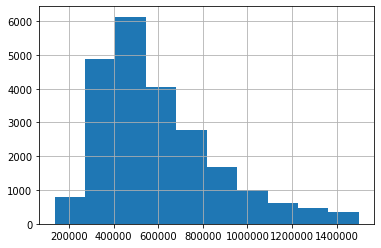

In [448]:
%matplotlib inline
df['cena'].hist()

<function matplotlib.pyplot.show(*args, **kw)>

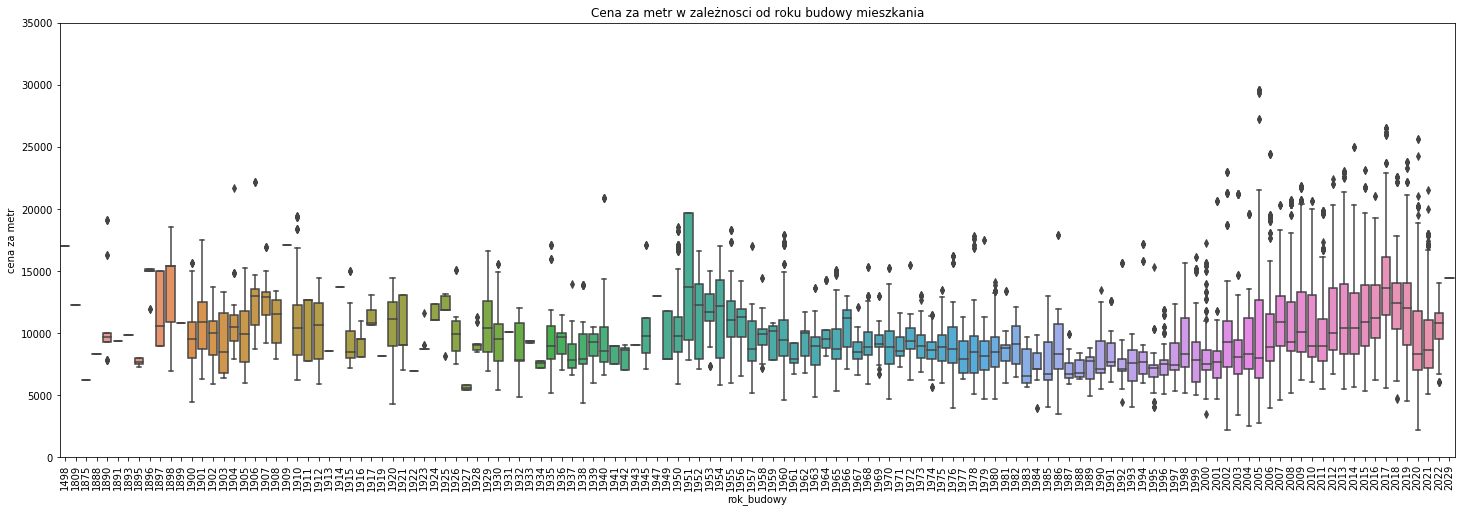

In [449]:
#var = 'rok_budowy'
#data = pd.concat([df['rok_budowy'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x=df['rok_budowy'], y=(df["cena"]/df['powierzchnia']))
fig.axis(ymin=0, ymax=35000);
plt.xticks(rotation=90);
plt.ylabel("cena za metr")
plt.title("Cena za metr w zależnosci od roku budowy mieszkania")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

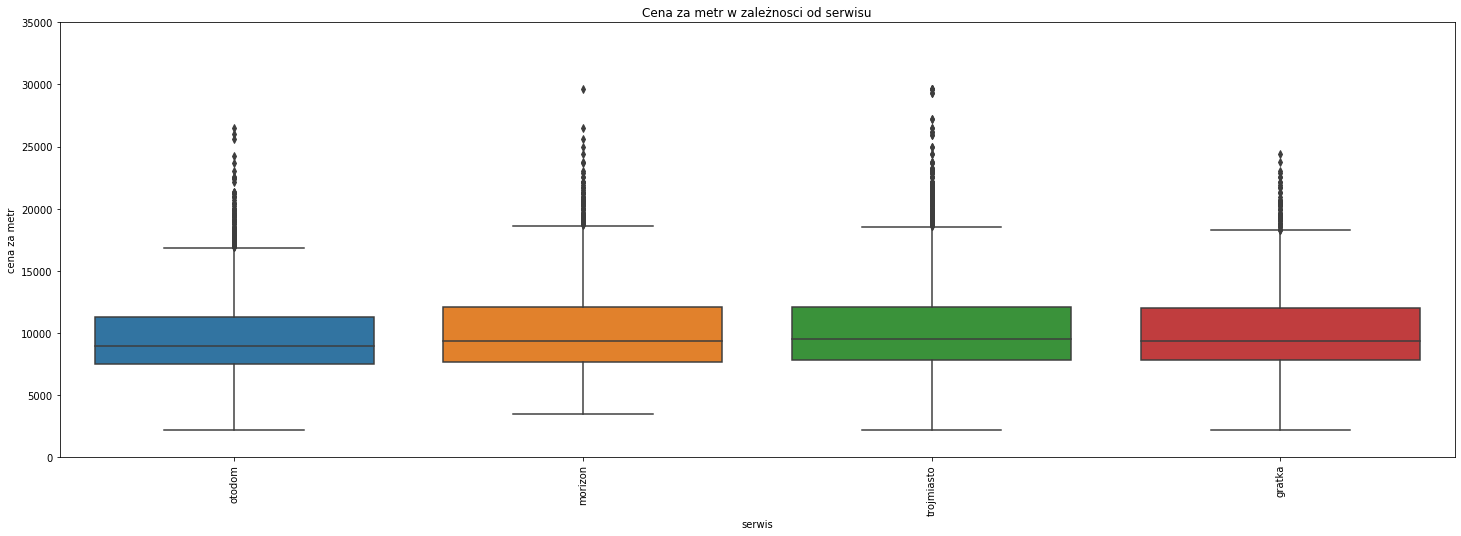

In [450]:
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x=df['serwis'], y=(df["cena"]/df['powierzchnia']))
fig.axis(ymin=0, ymax=35000);
plt.xticks(rotation=90);
plt.ylabel("cena za metr")
plt.title("Cena za metr w zależnosci od serwisu")
plt.show

## Dodatkowy preprocessing

### Sprawdzenie braków w danych

In [492]:
df.isna().sum() #sprawdzenie braków w danych (adres - 2)

kuchnia                      0
rynek                        0
balkon                       0
liczba_pieter_budynku        0
rok_budowy                   0
miasto                       0
liczba_pokoi                 0
wykonczenie                  0
ulica                        0
pietro                       0
rodzaj_zabudowy              0
powierzchnia                 0
dzielnica                    0
forma-wlasnosci              0
adres                        0
serwis                       0
material_budynku             0
oferta                       0
ogrzewanie                   0
winda                        0
czynsz                       0
typ_ogrzewania               0
dodatkowe_informacje         0
ulica_i_nr                   0
zbior                        0
cena                         0
ogrzewanie_merged            0
rynek2                       0
winda1                       0
piwnica                      0
miejsce_parkingowe           0
balkon1                      0
balkon_m

In [452]:
df=df.dropna(subset=['adres'])# usunięcie dwóch rekordów, gdzie brakuje adresów

In [278]:
#df['kuchnia'].value_counts() #71% BRAKÓW DANYCH - nie brałabym do analizy

In [279]:
#df['liczba_pieter_budynku'].value_counts() #mniej niż 1% braków w danych - brałabym do analizy

In [280]:
#df['liczba_pokoi'].value_counts() #mniej niż 1 proc. braków - brałabym do analizy

In [281]:
#df['pietro'].value_counts() #0% braków w danych - brałabym do analizy

In [282]:
#df['powierzchnia'].value_counts() 

### Łączenie kolumny ogrzewanie i typ ogrzewania

In [283]:
#df['ogrzewanie'].value_counts() 

In [284]:
#df['typ_ogrzewania'].value_counts() #moja propozycja, żeby połączyć te dwie cechy tak żeby były katedorie wyznaczone w cesze "ogrzewanie"

In [453]:
df["ogrzewanie_merged"] = df.ogrzewanie + df.typ_ogrzewania
df.ogrzewanie_merged =df.ogrzewanie_merged.str.replace("-1-1",'-1')
df.ogrzewanie_merged =df.ogrzewanie_merged.str.replace("-1","")
df.ogrzewanie_merged = df.ogrzewanie_merged.str.lower()
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "miejskie" if 'miejskie' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "miejskie" if 'miejske' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "miejskie" if 'miejski' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "miejskie" if 'sieć miejska' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "miejskie" if 'miasto' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "c. o." if 'c. o' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "c. o." if 'co' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "centralne" if 'centr' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "centralne" if 'cen' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "kotłownia" if 'kotłownia w bloku' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "kotłownia" if 'kotłownia lokalna' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "gazowe" if 'gaz' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "elektryczne" if 'elektryczne' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'pompa ciepła' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'kominkowe' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'etażowe' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'piec' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'węglowe' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'podłogowe' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'logotermy' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'oc' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'piecekaflowe' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "inne" if 'ec' in x else x)
df.ogrzewanie_merged = df.ogrzewanie_merged.apply(lambda x: "" if '-1' in x else x)
df["ogrzewanie_merged"].value_counts() ##54% BRAKÓW DANYCH
df["ogrzewanie_merged"].value_counts()

               11886
miejskie        8669
gazowe          1230
c. o.            327
elektryczne      220
centralne        195
inne             165
kotłownia         65
brak               3
(nieznane)         2
Name: ogrzewanie_merged, dtype: int64

### Zamiana braków danych w cesze "rynek" na podstawie roku budowy

In [286]:
#df['rynek'].value_counts() # ok. 60% BRAKÓW DANYCH

In [287]:
#df['rok_budowy'].value_counts() #100% DANYCH

In [288]:
#df[df['rok_budowy']>=2020] # lista nieruchomości z rynku pierwotnego

In [454]:
# Utworzenie nowej cechy "rynek2", która powstała na podstawie zmiennej rok budowy
df['rynek2']=np.where(df['rok_budowy']<2020, 'wtórny', 'pierwotny')
df['rynek2'].value_counts() # 100% DANYCH

wtórny       19641
pierwotny     3121
Name: rynek2, dtype: int64

### Rozbicie cechy "dodatkowe informacje" do uzupełnienia braków w danych

In [290]:
#df['dodatkowe_informacje'].value_counts()

In [455]:
df['winda1']=np.where(df['dodatkowe_informacje']=='winda', '1', '0')
df['winda1'].value_counts()

0    22762
Name: winda1, dtype: int64

In [456]:
winda=[]
balkon=[]
piwnica=[]
miejsce_parkingowe=[]
for i in df['dodatkowe_informacje']:
    if "Winda" in i:
        winda.append('tak') 
    else:
        winda.append(-1)
    if "Balkon" in i:
        balkon.append("tak") 
    else:
        balkon.append(-1)
    if "Piwnica" in i:
        piwnica.append('tak') 
    else:
        piwnica.append(-1)
    if  "Garaż" in i or "Miejsce parkingowe" in i:
        miejsce_parkingowe.append('tak') 
    else:
        miejsce_parkingowe.append(-1)

In [457]:
df['piwnica']=piwnica
df['miejsce_parkingowe']=miejsce_parkingowe
df['balkon1']=balkon
df['winda1']=winda

In [294]:
#df['piwnica'].value_counts() # 80% BRAKÓW W DANYCH!

In [295]:
#df['miejsce_parkingowe'].value_counts() # 80% BRAKÓW W DANYCH

In [296]:
#df['balkon1'].value_counts()

In [297]:
#df['balkon'].value_counts()

In [458]:
df["balkon_merged"] = df.balkon.astype(str) + df.balkon1.astype(str)
df.balkon_merged =df.balkon_merged.str.replace("-1-1","-1")
df.balkon_merged =df.balkon_merged.str.replace("-1tak",'tak')
df.balkon_merged =df.balkon_merged.str.replace("tak -1",'tak')
df.balkon_merged =df.balkon_merged.str.replace("nie -1",'nie')
df["balkon_merged"].value_counts() # 68% BRAKÓW W DANYCH

-1     15082
tak     7374
nie      306
Name: balkon_merged, dtype: int64

In [299]:
#df['winda1'].value_counts()

In [300]:
#df['winda'].value_counts()

In [459]:
df["winda_merged"] = df.winda.astype(str) + df.winda1.astype(str)
df.winda_merged =df.winda_merged.str.replace("-1-1","-1")
df.winda_merged =df.winda_merged.str.replace("-1tak",'tak')
df.winda_merged =df.winda_merged.str.replace("0-1",'nie')
df.winda_merged =df.winda_merged.str.replace("1-1",'tak')
df["winda_merged"].value_counts() #64% BRAKÓW W DANYCH

-1     14232
tak     5737
nie     2793
Name: winda_merged, dtype: int64

### Uporządkowanie takich cech jak: 'wykonczenie', 'materiał budynku', 'ogrzewanie','forma wlasnosci'

In [302]:
#df['wykonczenie'].value_counts()

In [460]:
df.wykonczenie = df.wykonczenie.apply(lambda x: "do remontu" if 'doremontu' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do wykończenia" if 'dowykończenia' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do remontu" if 'do odświeżenia' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do remontu" if 'do odnowienia' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do remontu" if 'do remontu kapit.' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do zamieszkania" if 'dozamieszkania' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "do zamieszkania" if 'do wprowadzenia' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "stan deweloperski" if 'deweloperski' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "po remoncie" if 'po generalnym remoncie' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "po remoncie" if 'świeżo po remoncie' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "po remoncie" if 'po odświeżeniu' in x else x)
df.wykonczenie = df.wykonczenie.apply(lambda x: "dobry" if 'dobry poziom' in x else x)
df['wykonczenie'].value_counts() #78% braków danych

-1                        17172
do zamieszkania            2333
do wykończenia             1320
do remontu                  637
wysoki standard             460
stan deweloperski           229
dobry                       229
bardzo wysoki standard      170
bardzo dobry                115
po remoncie                  28
do adaptacji                 21
normalny                     15
idealny                      13
nowy                         11
podwyższony                   3
komfort                       2
luksusowy                     2
wykończony                    2
Name: wykonczenie, dtype: int64

In [461]:
df.material_budynku = df.material_budynku.apply(lambda x: "cegła" if 'cegła czerwona' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "cegła" if 'cegła przedwojenna' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "cegła" if 'cegła stara' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "cegła" if 'cegła + styropian' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "beton" if 'betonkomórkowy' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "beton" if 'beton komórkowy' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "mieszana" if 'beton, cegła' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "żelbet" if 'konstrukcja żelbetowa' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "mieszana" if 'cegła, płyta' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "mieszana" if 'beton, ocieplony, płyta' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "mieszana" if 'beton, płyta' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'murowana' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'porotherm' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'rama h' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'gazobeton' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'drewno' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'bloczki' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'pustak żużlowy' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'cement' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'pustak ceramiczny' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "inna" if 'płyta po termomodernizacji' in x else x)
df.material_budynku = df.material_budynku.apply(lambda x: "mieszana" if 'zróżnicowany' in x else x)
df['material_budynku'].value_counts()# 87% BRAKÓW DANYCH

-1              19183
cegła            1384
wielka płyta      595
pustak            529
inne              437
silikat           224
mieszana          138
beton              77
żelbet             72
ytong              72
inna               27
tradycyjna         24
Name: material_budynku, dtype: int64

In [462]:
df['forma-wlasnosci']=df['forma-wlasnosci'].str.lower().str.strip()
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spółdzielcze-własnościowe",'spółdzielcze własnościowe')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spółdzielcze-własnościowe z kw",'spółdzielcze własnościowe z kw')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spół. własnościowe z kw",'spółdzielcze własnościowe z kw')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spółdzielcza własnościowa z kw",'spółdzielcze własnościowe z kw')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("własność",'pełna własność')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("odrębna własność lokalu",'odrębna własność')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("-",'-1')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("(nieznany)",'-1')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spółdzielcze wł. z kw",'spółdzielcze własnościowe z kw')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("spół. własnościowe",'spółdzielcze własnościowe')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("wieczyste użytkowanie",'użytkowanie wieczyste')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("hipoteczne",'pełna własność (hipoteczne)')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("pełna własność(hipoteczne)",'pełna własność (hipoteczne)')
df["forma-wlasnosci"] = df["forma-wlasnosci"].replace("ekspektatywa",'inna')
df['forma-wlasnosci'].value_counts() #95% BRAKÓW W DANYCH

-1                                  20937
pełna własność                       1577
spółdzielcze własnościowe             100
spółdzielcze własnościowe z kw         89
odrębna własność                       32
inna                                   10
pełna własność (hipoteczne)             6
użytkowanie wieczyste                   4
spółdzielcza własnościowa bez kw        3
współwłasność                           3
umowa z developerem                     1
Name: forma-wlasnosci, dtype: int64

### Miasto

In [463]:
df['miasto'].value_counts() # Występuje Rumia, Chwaszczyno i Żukowo, a oprócz tego mamy 10 tyś. braków w danych!!

-1             10512
Gdańsk          7810
Gdynia          3516
Sopot            914
Rumia              5
Chwaszczyno        4
Żukowo             1
Name: miasto, dtype: int64

In [464]:
def find_city(address):
    miasta = ['gdańsk', 'gdynia', 'sopot','gdansk']
    for m in miasta:
        if m in address:
            return m
    return np.nan

In [465]:
df['adres']=df['adres'].astype('str').str.lower()
df['miasto1']=df['adres'].apply(lambda x: find_city(x))

In [466]:
df['miasto1'].isna().sum()
df=df.dropna(subset=['miasto1'])

In [467]:
(df['miasto1']).value_counts()

gdańsk    14518
gdynia     6183
sopot      2022
gdansk       16
Name: miasto1, dtype: int64

In [468]:
df.miasto1 = df.miasto1.apply(lambda x: "gdańsk" if 'gdansk' in x else x)

<function matplotlib.pyplot.show(*args, **kw)>

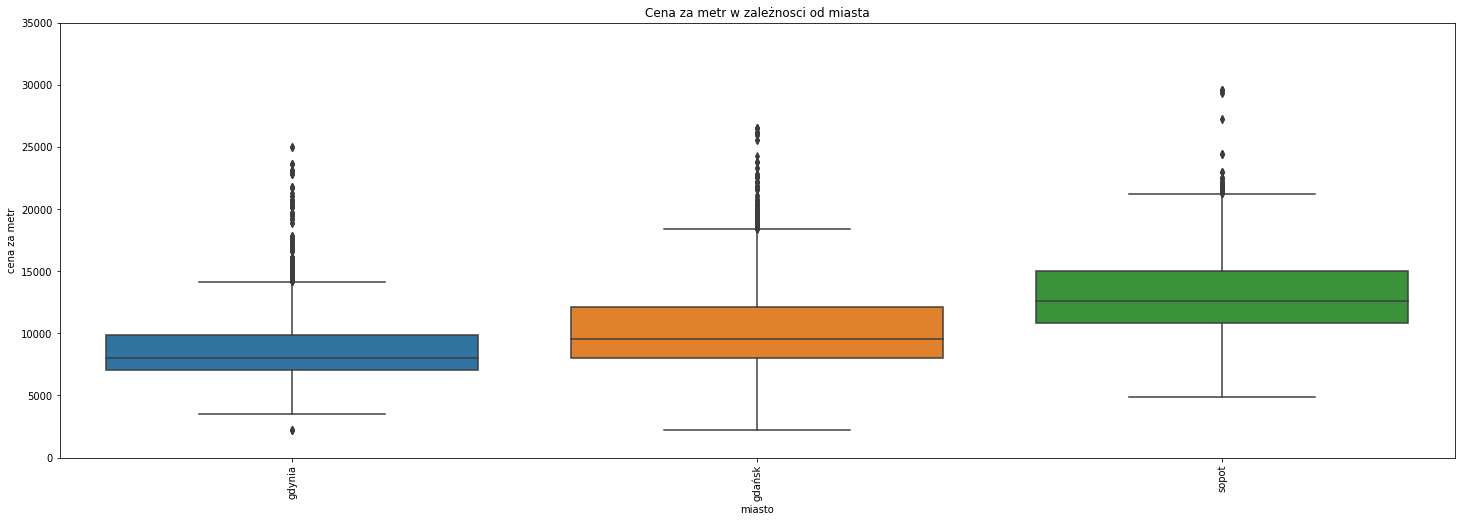

In [469]:
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x=df['miasto1'], y=(df["cena"]/df['powierzchnia']))
fig.axis(ymin=0, ymax=35000);
plt.xticks(rotation=90);
plt.ylabel("cena za metr")
plt.xlabel("miasto")
plt.title("Cena za metr w zależnosci od miasta")
plt.show

### Dzielnica - przyporządkowanie dzielnicy na podstawie cechy adres

In [470]:
#df['adres'].value_counts()

In [471]:
df['adres']=df['adres'].str.split(",")

dzielnica=[]
for i in df['adres']:
    try:
        if i is not np.nan:
            dzielnica.append(i[1])
        else:
            dzielnica.append('-1')
    except IndexError:
        dzielnica.append('-1')
        
df['dzielnica1']=dzielnica

df.dzielnica1=df.dzielnica1.replace(np.nan,'-1')
df['dzielnica']=df['dzielnica'].str.lower().str.strip()
df['dzielnica1']=df['dzielnica1'].str.lower().str.strip() #DANA NIE DOKŁADNE - LEPIEJ ZAJĄĆ SIĘ SZEROKOŚCIĄ I DŁUGOŚCIĄ GEOGRAFICZNĄ -> PATRZ KOD DARKA!

In [472]:
#df['dzielnica1'].value_counts()

### Znalezienie danych geolokalizacyjnych - DO ZROBIENIA

In [473]:
# Dwa geolocatory, które mają się uzupełniać
geolocator = Nominatim(user_agent='') 
geolocatorGoogle = GoogleV3(api_key='') # Podmienić na swoje API

In [475]:
def okreslAdres(address):
    '''
    Funkcja określa adres i współrzędne nieruchomości na bazie adresów w kolumnie ADRES
    '''
    try:
        locData = geolocator.geocode(address)
        # Jeżeli Nominatim nie poradzi sobie z wyznaczeniem współrzędnych, korzystamy z Google
        if locData is None:
            return geolocatorGoogle.geocode(address)
        else:
            return locData
    except:
        # Czasami trzeba odpytać jeszcze raz, po krótkiej przerwie...
        try:
            sleep(1)
            locData = geolocator.geocode(address)
            if locData is None:
                return geolocatorGoogle.geocode(address)
            else:
                return locData
        except:
            # ...a czasami po dłuższej.
            try:
                sleep(5)
                locData = geolocator.geocode(address)
                if locData is None:
                    return geolocatorGoogle.geocode(address)
                else:
                    return locData
            except:
                return np.nan

def setBCoordinate(adres):
  '''
  Funkcja wyciąga współrzędną B z wcześniej wyznaczonych adresów za pomocą funkcji okreslAdres
  '''
  try:
    return adres[1][0]
  except:
    return np.nan

def setLCoordinate(adres):
  '''
  Funkcja wyciąga współrzędną L z wcześniej wyznaczonych adresów za pomocą funkcji okreslAdres
  '''
  try:
    return adres[1][1]
  except:
    return np.nan

def obliczenieOdleglosciOdCentrum(B, L, city):
    '''
Funkcja oblicza odległość pomiędzy centrum miasta a nieruchomością
@param
B - współrzędna B nieruchomości
L - współrzędna L nieruchomości
city - miasto, w ktorym znajduje się nieruchomość
Bc, Lc to Współrzędne centrum
    ''' 
    if city == 'gdańsk':
        Bc = 54.3475
        Lc = 18.645278
        return float(distance.distance((B,L), (Bc, Lc)).km)
    
    elif city == "gdynia":
        Bc = 54.519167
        Lc = 18.539444
        return float(distance.distance((B,L), (Bc, Lc)).km)
    
    elif city == 'sopot':
        Bc = 54.441944
        Lc = 18.559722
        return float(distance.distance((B,L), (Bc, Lc)).km)

    else:
        print('Sth wrong')

In [490]:
# Zamian adresów na adresy + współrzędne w formacie geopy
# !!! UWAGA - zajmuje to ok 3h !!!

tqdm.pandas()
df['adres_new'] = df['adres'].iloc[13000::].progress_apply(lambda x: okreslAdres(x))


  1%|▌                                                                             | 71/9739 [00:36<1:24:18,  1.91it/s]


  1%|█                                                                            | 140/9739 [01:15<1:22:54,  1.93it/s]


  2%|█▋                                                                           | 211/9739 [02:01<1:47:44,  1.47it/s]


  3%|██▏                                                                          | 281/9739 [02:50<1:20:16,  1.96it/s]


  4%|██▊                                                                          | 351/9739 [03:27<1:15:29,  2.07it/s]


  4%|███▎                                                                         | 420/9739 [04:02<1:19:51,  1.94it/s]


  5%|███▊                                                                         | 490/9739 [04:37<1:08:21,  2.25it/s]


  6%|████▍                                                                        | 559/9739 [05:14<1:16:09,  2.01it/s]


  6%|████▉                                                                        | 627/9739 [05:50<1:17:14,  1.97it/s]


  7%|█████▍                                                                       | 695/9739 [06:24<1:09:42,  2.16it/s]


  8%|██████                                                                       | 765/9739 [06:59<1:14:04,  2.02it/s]


  9%|██████▌                                                                      | 837/9739 [07:36<1:42:34,  1.45it/s]


  9%|███████▏                                                                     | 906/9739 [08:11<1:06:00,  2.23it/s]


 10%|███████▋                                                                     | 974/9739 [08:45<1:13:49,  1.98it/s]


 11%|████████▏                                                                   | 1044/9739 [09:25<2:57:22,  1.22s/it]


 11%|████████▋                                                                   | 1114/9739 [10:01<1:12:53,  1.97it/s]


 12%|█████████▏                                                                  | 1183/9739 [10:35<1:08:37,  2.08it/s]


 13%|█████████▊                                                                  | 1251/9739 [11:10<1:09:27,  2.04it/s]


 14%|██████████▎                                                                 | 1321/9739 [11:46<1:19:17,  1.77it/s]


 14%|██████████▊                                                                 | 1389/9739 [12:21<1:22:51,  1.68it/s]


 15%|███████████▎                                                                | 1457/9739 [12:56<1:02:19,  2.21it/s]


 16%|███████████▉                                                                | 1525/9739 [13:38<1:07:41,  2.02it/s]


 16%|████████████▍                                                               | 1595/9739 [14:14<1:47:51,  1.26it/s]


 17%|█████████████▎                                                                | 1665/9739 [14:50<59:16,  2.27it/s]


 18%|█████████████▌                                                              | 1734/9739 [15:26<1:09:31,  1.92it/s]


 19%|██████████████                                                              | 1802/9739 [16:01<1:06:13,  2.00it/s]


 19%|██████████████▌                                                             | 1870/9739 [16:40<1:21:19,  1.61it/s]


 20%|███████████████▌                                                              | 1938/9739 [17:21<59:49,  2.17it/s]


 21%|███████████████▋                                                            | 2006/9739 [17:55<1:09:21,  1.86it/s]


 21%|████████████████▏                                                           | 2074/9739 [18:32<1:22:46,  1.54it/s]


 22%|█████████████████▏                                                            | 2142/9739 [19:08<58:58,  2.15it/s]


 23%|█████████████████▋                                                            | 2213/9739 [19:44<59:48,  2.10it/s]


 23%|█████████████████▊                                                          | 2282/9739 [20:18<1:01:44,  2.01it/s]


 24%|██████████████████▊                                                           | 2350/9739 [20:53<58:14,  2.11it/s]


 25%|███████████████████▎                                                          | 2418/9739 [21:32<57:44,  2.11it/s]


 26%|███████████████████▉                                                          | 2487/9739 [22:07<52:59,  2.28it/s]


 26%|████████████████████▍                                                         | 2556/9739 [22:41<50:20,  2.38it/s]


 27%|████████████████████▌                                                       | 2627/9739 [23:17<1:02:19,  1.90it/s]


 28%|█████████████████████                                                       | 2699/9739 [23:56<1:05:31,  1.79it/s]


 28%|█████████████████████▌                                                      | 2769/9739 [24:40<1:20:04,  1.45it/s]


 29%|██████████████████████▏                                                     | 2840/9739 [25:16<1:00:32,  1.90it/s]


 30%|██████████████████████▋                                                     | 2910/9739 [25:52<1:05:46,  1.73it/s]


 31%|███████████████████████▊                                                      | 2979/9739 [26:28<57:44,  1.95it/s]


 31%|████████████████████████▍                                                     | 3047/9739 [27:04<56:08,  1.99it/s]


 32%|████████████████████████▎                                                   | 3116/9739 [27:40<1:19:59,  1.38it/s]


 33%|█████████████████████████▌                                                    | 3185/9739 [28:15<52:55,  2.06it/s]


 33%|██████████████████████████                                                    | 3255/9739 [28:50<47:34,  2.27it/s]


 34%|██████████████████████████▌                                                   | 3324/9739 [29:26<46:03,  2.32it/s]


 35%|██████████████████████████▍                                                 | 3392/9739 [30:01<1:00:16,  1.76it/s]


 36%|███████████████████████████▋                                                  | 3462/9739 [30:37<47:56,  2.18it/s]


 36%|████████████████████████████▎                                                 | 3532/9739 [31:13<46:45,  2.21it/s]


 37%|████████████████████████████▊                                                 | 3601/9739 [31:49<58:10,  1.76it/s]


 38%|█████████████████████████████▍                                                | 3669/9739 [32:23<52:45,  1.92it/s]


 38%|█████████████████████████████▉                                                | 3738/9739 [33:00<57:08,  1.75it/s]


 39%|██████████████████████████████▍                                               | 3807/9739 [33:34<48:25,  2.04it/s]


 40%|███████████████████████████████                                               | 3875/9739 [34:08<49:36,  1.97it/s]


 41%|███████████████████████████████▌                                              | 3945/9739 [34:44<51:31,  1.87it/s]


 41%|████████████████████████████████▏                                             | 4013/9739 [35:18<51:43,  1.84it/s]


 42%|████████████████████████████████▋                                             | 4081/9739 [35:52<50:15,  1.88it/s]


 43%|████████████████████████████████▍                                           | 4150/9739 [36:28<1:06:23,  1.40it/s]


 43%|█████████████████████████████████▊                                            | 4219/9739 [37:04<47:23,  1.94it/s]


 44%|██████████████████████████████████▎                                           | 4288/9739 [37:39<46:43,  1.94it/s]


 45%|██████████████████████████████████▉                                           | 4359/9739 [38:16<48:32,  1.85it/s]


 45%|███████████████████████████████████▍                                          | 4428/9739 [38:53<54:00,  1.64it/s]


 46%|████████████████████████████████████                                          | 4496/9739 [39:27<44:54,  1.95it/s]


 47%|████████████████████████████████████▌                                         | 4568/9739 [40:01<45:36,  1.89it/s]


 48%|█████████████████████████████████████▏                                        | 4636/9739 [40:35<41:53,  2.03it/s]


 48%|█████████████████████████████████████▋                                        | 4704/9739 [41:09<42:08,  1.99it/s]


 49%|██████████████████████████████████████▏                                       | 4772/9739 [41:43<39:51,  2.08it/s]


 50%|██████████████████████████████████████▊                                       | 4840/9739 [42:17<42:15,  1.93it/s]


 50%|███████████████████████████████████████▎                                      | 4908/9739 [42:54<40:04,  2.01it/s]


 51%|███████████████████████████████████████▊                                      | 4976/9739 [43:28<39:22,  2.02it/s]


 52%|████████████████████████████████████████▍                                     | 5044/9739 [44:02<38:27,  2.03it/s]


 52%|████████████████████████████████████████▉                                     | 5112/9739 [44:36<37:44,  2.04it/s]


 53%|█████████████████████████████████████████▍                                    | 5180/9739 [45:10<38:42,  1.96it/s]


 54%|██████████████████████████████████████████                                    | 5248/9739 [45:44<37:10,  2.01it/s]


 55%|██████████████████████████████████████████▌                                   | 5317/9739 [46:18<36:14,  2.03it/s]


 55%|███████████████████████████████████████████▏                                  | 5385/9739 [46:52<34:21,  2.11it/s]


 56%|███████████████████████████████████████████▋                                  | 5453/9739 [47:27<35:27,  2.01it/s]


 57%|████████████████████████████████████████████▏                                 | 5521/9739 [48:01<34:54,  2.01it/s]


 57%|████████████████████████████████████████████▊                                 | 5589/9739 [48:36<34:21,  2.01it/s]


 58%|█████████████████████████████████████████████▎                                | 5657/9739 [49:10<33:24,  2.04it/s]


 59%|█████████████████████████████████████████████▊                                | 5725/9739 [49:44<32:18,  2.07it/s]


 59%|██████████████████████████████████████████████▍                               | 5793/9739 [50:18<33:56,  1.94it/s]


 60%|██████████████████████████████████████████████▉                               | 5861/9739 [50:52<33:53,  1.91it/s]


 61%|███████████████████████████████████████████████▍                              | 5929/9739 [51:27<33:58,  1.87it/s]


 62%|████████████████████████████████████████████████                              | 5997/9739 [52:02<30:51,  2.02it/s]


 62%|████████████████████████████████████████████████▌                             | 6065/9739 [52:36<30:17,  2.02it/s]


 63%|█████████████████████████████████████████████████                             | 6133/9739 [53:10<30:15,  1.99it/s]


 64%|█████████████████████████████████████████████████▋                            | 6201/9739 [53:44<29:23,  2.01it/s]


 64%|██████████████████████████████████████████████████▏                           | 6269/9739 [54:32<28:36,  2.02it/s]


 65%|██████████████████████████████████████████████████▊                           | 6338/9739 [55:26<53:22,  1.06it/s]


 66%|███████████████████████████████████████████████████▎                          | 6406/9739 [56:10<37:53,  1.47it/s]


 66%|███████████████████████████████████████████████████▊                          | 6474/9739 [56:46<28:15,  1.93it/s]


 67%|████████████████████████████████████████████████████▍                         | 6542/9739 [57:19<26:14,  2.03it/s]


 68%|████████████████████████████████████████████████████▉                         | 6610/9739 [57:53<25:25,  2.05it/s]


 69%|█████████████████████████████████████████████████████▍                        | 6678/9739 [58:27<24:39,  2.07it/s]


 69%|██████████████████████████████████████████████████████                        | 6746/9739 [59:01<24:37,  2.03it/s]


 70%|██████████████████████████████████████████████████████▌                       | 6814/9739 [59:35<24:12,  2.01it/s]


 71%|█████████████████████████████████████████████████████▋                      | 6882/9739 [1:00:09<23:21,  2.04it/s]


 71%|██████████████████████████████████████████████████████▏                     | 6950/9739 [1:00:44<22:37,  2.05it/s]


 72%|██████████████████████████████████████████████████████▊                     | 7018/9739 [1:01:18<22:05,  2.05it/s]


 73%|███████████████████████████████████████████████████████▎                    | 7086/9739 [1:01:52<22:12,  1.99it/s]


 73%|███████████████████████████████████████████████████████▊                    | 7154/9739 [1:02:26<21:46,  1.98it/s]


 74%|████████████████████████████████████████████████████████▎                   | 7222/9739 [1:03:00<20:36,  2.04it/s]


 75%|████████████████████████████████████████████████████████▉                   | 7290/9739 [1:03:34<21:50,  1.87it/s]


 76%|█████████████████████████████████████████████████████████▍                  | 7358/9739 [1:04:08<19:12,  2.07it/s]


 76%|█████████████████████████████████████████████████████████▉                  | 7426/9739 [1:04:42<19:13,  2.01it/s]


 77%|██████████████████████████████████████████████████████████▍                 | 7494/9739 [1:05:16<20:25,  1.83it/s]


 78%|███████████████████████████████████████████████████████████                 | 7562/9739 [1:05:50<17:35,  2.06it/s]


 78%|███████████████████████████████████████████████████████████▌                | 7630/9739 [1:06:24<18:15,  1.92it/s]


 79%|████████████████████████████████████████████████████████████                | 7698/9739 [1:06:58<16:27,  2.07it/s]


 80%|████████████████████████████████████████████████████████████▌               | 7766/9739 [1:07:32<16:08,  2.04it/s]


 80%|█████████████████████████████████████████████████████████████▏              | 7834/9739 [1:08:06<15:22,  2.07it/s]


 81%|█████████████████████████████████████████████████████████████▋              | 7902/9739 [1:08:40<16:14,  1.89it/s]


 82%|██████████████████████████████████████████████████████████████▏             | 7970/9739 [1:09:14<14:09,  2.08it/s]


 83%|██████████████████████████████████████████████████████████████▋             | 8038/9739 [1:09:48<14:39,  1.94it/s]


 83%|███████████████████████████████████████████████████████████████▎            | 8106/9739 [1:10:22<13:15,  2.05it/s]


 84%|███████████████████████████████████████████████████████████████▊            | 8174/9739 [1:10:56<12:56,  2.01it/s]


 85%|████████████████████████████████████████████████████████████████▎           | 8242/9739 [1:11:30<11:29,  2.17it/s]


 85%|████████████████████████████████████████████████████████████████▊           | 8310/9739 [1:12:08<18:12,  1.31it/s]


 86%|█████████████████████████████████████████████████████████████████▍          | 8378/9739 [1:12:42<11:12,  2.02it/s]


 87%|█████████████████████████████████████████████████████████████████▉          | 8446/9739 [1:13:16<10:43,  2.01it/s]


 87%|██████████████████████████████████████████████████████████████████▍         | 8514/9739 [1:13:50<10:12,  2.00it/s]


 88%|██████████████████████████████████████████████████████████████████▉         | 8582/9739 [1:14:24<09:46,  1.97it/s]


 89%|███████████████████████████████████████████████████████████████████▌        | 8650/9739 [1:14:58<08:54,  2.04it/s]


 90%|████████████████████████████████████████████████████████████████████        | 8718/9739 [1:15:32<08:19,  2.04it/s]


 90%|████████████████████████████████████████████████████████████████████▌       | 8786/9739 [1:16:06<07:50,  2.03it/s]


 91%|█████████████████████████████████████████████████████████████████████       | 8854/9739 [1:16:40<07:07,  2.07it/s]


 92%|█████████████████████████████████████████████████████████████████████▌      | 8922/9739 [1:17:14<07:07,  1.91it/s]


 92%|██████████████████████████████████████████████████████████████████████▏     | 8990/9739 [1:17:48<06:44,  1.85it/s]


 93%|██████████████████████████████████████████████████████████████████████▋     | 9058/9739 [1:18:22<05:49,  1.95it/s]


 94%|███████████████████████████████████████████████████████████████████████▏    | 9126/9739 [1:18:56<05:26,  1.88it/s]


 94%|███████████████████████████████████████████████████████████████████████▋    | 9194/9739 [1:19:30<04:30,  2.01it/s]


 95%|████████████████████████████████████████████████████████████████████████▎   | 9262/9739 [1:20:04<03:56,  2.02it/s]


 96%|████████████████████████████████████████████████████████████████████████▊   | 9330/9739 [1:20:38<03:23,  2.01it/s]


 96%|█████████████████████████████████████████████████████████████████████████▎  | 9398/9739 [1:21:13<02:57,  1.92it/s]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 9466/9739 [1:21:47<02:09,  2.11it/s]


 98%|██████████████████████████████████████████████████████████████████████████▍ | 9534/9739 [1:22:21<01:41,  2.03it/s]


 99%|██████████████████████████████████████████████████████████████████████████▉ | 9602/9739 [1:22:55<01:05,  2.08it/s]


 99%|███████████████████████████████████████████████████████████████████████████▍| 9670/9739 [1:23:29<00:33,  2.04it/s]


100%|████████████████████████████████████████████████████████████████████████████| 9739/9739 [1:24:04<00:00,  2.04it/s]

In [432]:
for i, row in tqdm(df.iterrows()):
    if row['adres_new'] is np.nan:
        row['adres_new'] = okreslAdres(row['adres'])


0it [00:00, ?it/s]
1it [00:00,  1.83it/s]
4it [00:01,  2.28it/s]
6it [00:01,  2.52it/s]
7it [00:02,  2.12it/s]
8it [00:02,  2.62it/s]
9it [00:03,  2.43it/s]
19it [00:03,  3.31it/s]
22it [00:04,  3.68it/s]
28it [00:04,  4.46it/s]
32it [00:05,  5.65it/s]
34it [00:05,  4.63it/s]
35it [00:06,  3.03it/s]
37it [00:06,  3.23it/s]
40it [00:07,  4.09it/s]
42it [00:07,  3.76it/s]
48it [00:07,  4.99it/s]
50it [00:08,  3.39it/s]
52it [00:09,  3.59it/s]
55it [00:10,  3.67it/s]
60it [00:10,  4.88it/s]
71it [00:11,  6.33it/s]
75it [00:11,  6.99it/s]
77it [00:12,  5.15it/s]
91it [00:12,  6.71it/s]
102it [00:12,  8.88it/s]
109it [00:13,  9.12it/s]
114it [00:14,  9.38it/s]
116it [00:14,  9.08it/s]
118it [00:15,  3.67it/s]
135it [00:15,  5.15it/s]
139it [00:16,  4.76it/s]
142it [00:17,  4.69it/s]
144it [00:17,  4.97it/s]
148it [00:18,  5.35it/s]
152it [00:19,  5.81it/s]
156it [00:19,  6.92it/s]
158it [00:20,  3.77it/s]
163it [00:20,  4.72it/s]
169it [00:21,  5.82it/s]
178it [00:21,  7.25it/s]
184it [00:

1468it [02:47,  4.34it/s]
1471it [02:48,  4.49it/s]
1473it [02:48,  4.55it/s]
1474it [02:49,  3.29it/s]
1478it [02:49,  3.86it/s]
1493it [02:49,  5.34it/s]
1495it [02:51,  3.16it/s]
1497it [02:51,  3.75it/s]
1501it [02:52,  4.29it/s]
1504it [02:52,  4.45it/s]
1513it [02:53,  5.97it/s]
1522it [02:53,  7.26it/s]
1524it [02:54,  5.30it/s]
1526it [02:54,  6.24it/s]
1530it [02:55,  6.40it/s]
1531it [02:55,  2.97it/s]
1533it [02:55,  3.90it/s]
1536it [02:56,  3.89it/s]
1545it [02:57,  5.25it/s]
1551it [02:57,  6.22it/s]
1553it [02:58,  3.85it/s]
1555it [02:58,  4.16it/s]
1559it [02:59,  4.86it/s]
1561it [02:59,  4.57it/s]
1564it [03:00,  4.85it/s]
1571it [03:00,  6.07it/s]
1572it [03:01,  3.82it/s]
1593it [03:02,  5.13it/s]
1595it [03:02,  6.03it/s]
1598it [03:03,  5.31it/s]
1604it [03:03,  6.79it/s]
1606it [03:04,  5.11it/s]
1611it [03:04,  6.19it/s]
1613it [03:05,  5.28it/s]
1620it [03:05,  6.29it/s]
1622it [03:06,  4.92it/s]
1626it [03:06,  6.04it/s]
1631it [03:07,  6.56it/s]
1633it [03:0

2825it [05:29,  4.73it/s]
2826it [05:30,  3.44it/s]
2827it [05:31,  2.34it/s]
2830it [05:31,  3.00it/s]
2832it [05:31,  3.10it/s]
2835it [05:32,  3.91it/s]
2842it [05:32,  4.90it/s]
2846it [05:33,  5.72it/s]
2848it [05:33,  4.94it/s]
2854it [05:34,  5.63it/s]
2856it [05:35,  4.97it/s]
2859it [05:35,  5.85it/s]
2861it [05:35,  4.72it/s]
2862it [05:36,  3.02it/s]
2867it [05:36,  4.09it/s]
2875it [05:37,  5.05it/s]
2886it [05:37,  6.81it/s]
2889it [05:38,  5.67it/s]
2891it [05:38,  5.98it/s]
2893it [05:39,  5.17it/s]
2899it [05:39,  6.41it/s]
2905it [05:40,  7.41it/s]
2911it [05:40,  7.68it/s]
2918it [05:41,  9.60it/s]
2921it [05:41,  7.44it/s]
2926it [05:42,  7.64it/s]
2933it [05:42,  9.57it/s]
2936it [05:43,  7.31it/s]
2939it [05:44,  6.43it/s]
2940it [05:44,  5.70it/s]
2951it [05:44,  7.31it/s]
2954it [05:45,  6.89it/s]
2958it [05:45,  6.77it/s]
2961it [05:46,  6.05it/s]
2966it [05:46,  7.45it/s]
2968it [05:48,  3.60it/s]
2977it [05:48,  4.95it/s]
2981it [05:48,  5.17it/s]
2985it [05:4

4346it [08:13,  4.49it/s]
4349it [08:13,  4.89it/s]
4351it [08:14,  4.78it/s]
4356it [08:14,  5.45it/s]
4365it [08:15,  6.72it/s]
4367it [08:15,  7.46it/s]
4377it [08:16,  8.66it/s]
4390it [08:17, 10.53it/s]
4392it [08:17, 10.94it/s]
4402it [08:18, 11.53it/s]
4404it [08:18, 10.05it/s]
4411it [08:18, 10.22it/s]
4413it [08:19,  6.20it/s]
4416it [08:19,  6.96it/s]
4418it [08:20,  6.21it/s]
4424it [08:21,  6.48it/s]
4426it [08:21,  6.56it/s]
4427it [08:22,  3.43it/s]
4432it [08:22,  4.15it/s]
4436it [08:22,  5.21it/s]
4437it [08:23,  3.14it/s]
4444it [08:24,  4.01it/s]
4454it [08:24,  5.44it/s]
4464it [08:24,  6.98it/s]
4467it [08:25,  6.93it/s]
4471it [08:26,  6.81it/s]
4480it [08:26,  8.61it/s]
4482it [08:26,  6.26it/s]
4485it [08:27,  6.03it/s]
4488it [08:28,  5.40it/s]
4490it [08:28,  5.72it/s]
4503it [08:29,  7.32it/s]
4510it [08:29,  8.20it/s]
4513it [08:29,  9.49it/s]
4515it [08:30,  6.63it/s]
4519it [08:30,  6.94it/s]
4522it [08:31,  6.17it/s]
4523it [08:32,  3.47it/s]
4550it [08:3

5775it [10:55, 10.15it/s]
5782it [10:55, 10.40it/s]
5792it [10:56, 11.76it/s]
5799it [10:56, 14.92it/s]
5802it [10:57,  6.30it/s]
5805it [10:57,  6.64it/s]
5807it [10:58,  5.20it/s]
5810it [10:59,  5.41it/s]
5812it [10:59,  4.52it/s]
5813it [10:59,  4.07it/s]
5816it [11:00,  4.34it/s]
5830it [11:01,  5.71it/s]
5833it [11:01,  6.52it/s]
5835it [11:02,  5.02it/s]
5838it [11:02,  4.98it/s]
5841it [11:03,  5.83it/s]
5842it [11:03,  3.28it/s]
5846it [11:03,  4.23it/s]
5848it [11:04,  3.84it/s]
5849it [11:05,  2.94it/s]
5853it [11:05,  3.75it/s]
5856it [11:06,  4.02it/s]
5861it [11:06,  4.75it/s]
5863it [11:07,  5.17it/s]
5869it [11:07,  6.02it/s]
5876it [11:08,  7.00it/s]
5883it [11:08,  9.29it/s]
5885it [11:09,  5.38it/s]
5887it [11:09,  5.68it/s]
5889it [11:10,  4.64it/s]
5891it [11:10,  4.87it/s]
5892it [11:11,  3.19it/s]
5906it [11:11,  4.30it/s]
5910it [11:12,  4.79it/s]
5911it [11:12,  4.97it/s]
5913it [11:13,  3.97it/s]
5914it [11:13,  3.72it/s]
5924it [11:14,  4.84it/s]
5927it [11:1

7235it [13:35,  4.83it/s]
7245it [13:36,  6.01it/s]
7252it [13:36,  7.72it/s]
7257it [13:37,  7.84it/s]
7274it [13:37,  9.99it/s]
7276it [13:38,  8.63it/s]
7279it [13:38,  7.02it/s]
7282it [13:39,  6.21it/s]
7283it [13:39,  6.01it/s]
7284it [13:40,  2.94it/s]
7288it [13:40,  3.83it/s]
7299it [13:41,  5.01it/s]
7301it [13:41,  5.30it/s]
7305it [13:42,  5.66it/s]
7309it [13:42,  5.90it/s]
7316it [13:43,  6.90it/s]
7317it [13:43,  6.29it/s]
7318it [13:44,  3.01it/s]
7321it [13:44,  3.79it/s]
7324it [13:45,  4.07it/s]
7325it [13:45,  3.39it/s]
7333it [13:46,  4.44it/s]
7334it [13:46,  2.93it/s]
7337it [13:47,  3.33it/s]
7343it [13:47,  4.43it/s]
7354it [13:48,  5.72it/s]
7356it [13:48,  5.98it/s]
7362it [13:49,  6.77it/s]
7364it [13:50,  4.14it/s]
7368it [13:50,  4.65it/s]
7370it [13:51,  4.12it/s]
7371it [13:51,  4.43it/s]
7374it [13:52,  4.32it/s]
7382it [13:52,  5.76it/s]
7385it [13:53,  5.47it/s]
7386it [13:53,  4.21it/s]
7387it [13:54,  3.01it/s]
7390it [13:54,  3.54it/s]
7401it [13:5

8606it [16:17,  2.28it/s]
8607it [16:18,  2.00it/s]
8608it [16:18,  1.87it/s]
8609it [16:19,  2.15it/s]
8610it [16:19,  1.96it/s]
8611it [16:20,  1.84it/s]
8612it [16:20,  2.13it/s]
8613it [16:21,  1.95it/s]
8614it [16:21,  2.22it/s]
8615it [16:22,  1.99it/s]
8616it [16:22,  1.87it/s]
8617it [16:23,  2.14it/s]
8618it [16:23,  1.84it/s]
8619it [16:24,  2.12it/s]
8620it [16:24,  1.94it/s]
8621it [16:25,  1.80it/s]
8622it [16:25,  2.28it/s]
8623it [16:26,  2.17it/s]
8624it [16:26,  2.10it/s]
8625it [16:27,  1.99it/s]
8626it [16:27,  2.06it/s]
8627it [16:28,  2.01it/s]
8628it [16:28,  1.88it/s]
8629it [16:29,  1.80it/s]
8630it [16:29,  2.07it/s]
8631it [16:30,  1.91it/s]
8632it [16:30,  2.19it/s]
8633it [16:31,  1.97it/s]
8634it [16:31,  1.82it/s]
8635it [16:32,  2.15it/s]
8636it [16:32,  1.97it/s]
8637it [16:33,  2.20it/s]
8638it [16:33,  1.96it/s]
8639it [16:34,  1.84it/s]
8640it [16:34,  2.19it/s]
8641it [16:35,  1.98it/s]
8642it [16:35,  1.94it/s]
8643it [16:36,  2.11it/s]
8644it [16:3

8922it [18:55,  2.16it/s]
8923it [18:56,  2.22it/s]
8924it [18:56,  1.84it/s]
8925it [18:57,  2.11it/s]
8926it [18:57,  1.90it/s]
8927it [18:58,  1.85it/s]
8928it [18:58,  2.12it/s]
8929it [18:59,  2.21it/s]
8930it [18:59,  2.12it/s]
8931it [19:00,  1.90it/s]
8932it [19:00,  1.81it/s]
8933it [19:01,  2.22it/s]
8934it [19:01,  1.94it/s]
8935it [19:02,  1.83it/s]
8936it [19:02,  2.11it/s]
8937it [19:03,  1.94it/s]
8938it [19:03,  2.14it/s]
8939it [19:04,  1.96it/s]
8940it [19:04,  1.84it/s]
8941it [19:05,  2.18it/s]
8942it [19:05,  1.99it/s]
8943it [19:06,  1.86it/s]
8944it [19:06,  2.13it/s]
8945it [19:07,  2.15it/s]
8946it [19:07,  2.15it/s]
8947it [19:08,  1.90it/s]
8948it [19:08,  1.87it/s]
8949it [19:09,  2.14it/s]
8950it [19:09,  1.96it/s]
8951it [19:10,  1.84it/s]
8952it [19:10,  2.12it/s]
8953it [19:11,  1.94it/s]
8954it [19:11,  1.84it/s]
8955it [19:12,  2.05it/s]
8956it [19:12,  1.96it/s]
8957it [19:13,  2.22it/s]
8958it [19:13,  1.95it/s]
8959it [19:14,  1.78it/s]
8960it [19:1

9237it [21:33,  2.20it/s]
9238it [21:33,  2.01it/s]
9239it [21:34,  2.16it/s]
9240it [21:34,  1.92it/s]
9241it [21:35,  2.11it/s]
9242it [21:35,  2.06it/s]
9243it [21:36,  1.91it/s]
9244it [21:36,  2.04it/s]
9245it [21:37,  2.01it/s]
9246it [21:37,  1.88it/s]
9247it [21:38,  2.18it/s]
9248it [21:38,  1.96it/s]
9249it [21:39,  1.84it/s]
9250it [21:39,  2.12it/s]
9251it [21:40,  1.89it/s]
9252it [21:40,  1.85it/s]
9253it [21:41,  2.13it/s]
9254it [21:41,  1.94it/s]
9255it [21:42,  2.21it/s]
9256it [21:42,  2.00it/s]
9257it [21:43,  1.87it/s]
9258it [21:43,  2.15it/s]
9259it [21:44,  1.91it/s]
9260it [21:44,  1.81it/s]
9261it [21:45,  2.15it/s]
9262it [21:45,  1.96it/s]
9263it [21:46,  2.23it/s]
9264it [21:46,  2.01it/s]
9265it [21:47,  1.87it/s]
9266it [21:47,  2.09it/s]
9267it [21:48,  2.18it/s]
9268it [21:48,  1.81it/s]
9269it [21:49,  2.09it/s]
9270it [21:49,  1.92it/s]
9271it [21:50,  2.14it/s]
9272it [21:50,  1.95it/s]
9273it [21:51,  1.88it/s]
9274it [21:51,  1.80it/s]
9275it [21:5

9552it [24:10,  2.01it/s]
9553it [24:11,  1.88it/s]
9554it [24:11,  1.80it/s]
9555it [24:12,  2.07it/s]
9556it [24:12,  1.92it/s]
9557it [24:13,  2.12it/s]
9558it [24:13,  2.00it/s]
9559it [24:14,  1.82it/s]
9560it [24:14,  2.17it/s]
9561it [24:15,  1.91it/s]
9562it [24:15,  1.87it/s]
9563it [24:16,  2.14it/s]
9564it [24:16,  1.96it/s]
9565it [24:17,  2.26it/s]
9566it [24:17,  1.99it/s]
9567it [24:18,  1.87it/s]
9568it [24:18,  2.14it/s]
9569it [24:19,  1.91it/s]
9570it [24:19,  1.86it/s]
9571it [24:20,  2.28it/s]
9572it [24:20,  2.19it/s]
9573it [24:21,  2.09it/s]
9574it [24:21,  2.09it/s]
9575it [24:22,  1.79it/s]
9576it [24:22,  2.07it/s]
9577it [24:23,  2.03it/s]
9578it [24:23,  1.79it/s]
9579it [24:24,  2.07it/s]
9580it [24:24,  2.17it/s]
9581it [24:25,  2.10it/s]
9582it [24:25,  1.93it/s]
9583it [24:26,  1.79it/s]
9584it [24:26,  2.13it/s]
9585it [24:27,  1.94it/s]
9586it [24:28,  1.77it/s]
9587it [24:28,  2.23it/s]
9588it [24:28,  1.94it/s]
9589it [24:29,  1.83it/s]
9590it [24:2

9867it [26:48,  1.86it/s]
9868it [26:48,  1.84it/s]
9869it [26:49,  2.17it/s]
9870it [26:49,  1.93it/s]
9871it [26:50,  2.26it/s]
9872it [26:50,  2.03it/s]
9873it [26:51,  1.88it/s]
9874it [26:51,  2.16it/s]
9875it [26:52,  1.96it/s]
9876it [26:52,  1.85it/s]
9877it [26:53,  2.13it/s]
9878it [26:53,  1.90it/s]
9879it [26:54,  1.85it/s]
9880it [26:54,  2.28it/s]
9881it [26:55,  1.91it/s]
9882it [26:55,  2.12it/s]
9883it [26:56,  2.20it/s]
9884it [26:56,  1.82it/s]
9885it [26:57,  2.10it/s]
9886it [26:57,  1.93it/s]
9887it [26:58,  1.83it/s]
9888it [26:58,  2.25it/s]
9889it [26:59,  1.70it/s]
9891it [27:00,  1.93it/s]
9892it [27:00,  1.83it/s]
9893it [27:01,  2.11it/s]
9894it [27:01,  2.02it/s]
9895it [27:02,  1.81it/s]
9896it [27:02,  2.09it/s]
9897it [27:03,  2.21it/s]
9898it [27:03,  2.10it/s]
9899it [27:04,  1.93it/s]
9900it [27:04,  1.83it/s]
9901it [27:05,  2.05it/s]
9902it [27:05,  1.95it/s]
9903it [27:06,  1.84it/s]
9904it [27:06,  2.05it/s]
9905it [27:07,  2.22it/s]
9906it [27:0

10178it [29:23,  2.15it/s]
10179it [29:24,  1.96it/s]
10180it [29:24,  2.23it/s]
10181it [29:25,  2.01it/s]
10182it [29:25,  1.93it/s]
10183it [29:26,  2.22it/s]
10184it [29:26,  1.93it/s]
10185it [29:27,  2.17it/s]
10186it [29:27,  2.12it/s]
10187it [29:28,  1.84it/s]
10188it [29:28,  1.77it/s]
10189it [29:29,  2.19it/s]
10190it [29:29,  1.87it/s]
10191it [29:30,  2.22it/s]
10192it [29:30,  1.92it/s]
10193it [29:31,  1.84it/s]
10194it [29:31,  2.05it/s]
10195it [29:32,  1.84it/s]
10196it [29:33,  1.83it/s]
10197it [29:33,  2.30it/s]
10198it [29:33,  1.89it/s]
10199it [29:34,  2.23it/s]
10200it [29:34,  1.95it/s]
10201it [29:35,  1.89it/s]
10202it [29:35,  2.16it/s]
10203it [29:36,  1.97it/s]
10204it [29:36,  1.85it/s]
10205it [29:37,  2.13it/s]
10206it [29:37,  2.21it/s]
10207it [29:38,  2.12it/s]
10208it [29:38,  2.07it/s]
10209it [29:39,  1.81it/s]
10210it [29:39,  2.14it/s]
10211it [29:40,  1.91it/s]
10212it [29:41,  1.78it/s]
10213it [29:41,  2.26it/s]
10214it [29:41,  1.90it/s]
1

10481it [31:55,  2.17it/s]
10482it [31:55,  1.92it/s]
10483it [31:56,  1.87it/s]
10484it [31:56,  2.14it/s]
10485it [31:57,  1.95it/s]
10486it [31:58,  1.80it/s]
10487it [31:58,  2.25it/s]
10488it [31:58,  1.93it/s]
10489it [31:59,  2.20it/s]
10490it [31:59,  1.99it/s]
10491it [32:00,  1.87it/s]
10492it [32:00,  2.14it/s]
10493it [32:01,  1.91it/s]
10494it [32:01,  1.86it/s]
10495it [32:02,  2.28it/s]
10496it [32:02,  2.20it/s]
10497it [32:03,  2.09it/s]
10498it [32:03,  1.93it/s]
10499it [32:04,  1.83it/s]
10500it [32:04,  2.10it/s]
10501it [32:05,  1.93it/s]
10502it [32:06,  1.79it/s]
10503it [32:06,  2.13it/s]
10504it [32:06,  1.90it/s]
10505it [32:07,  2.17it/s]
10506it [32:07,  2.02it/s]
10507it [32:08,  1.84it/s]
10508it [32:08,  2.18it/s]
10509it [32:09,  1.98it/s]
10510it [32:09,  1.86it/s]
10511it [32:10,  2.13it/s]
10512it [32:10,  1.95it/s]
10513it [32:11,  2.22it/s]
10514it [32:11,  1.94it/s]
10515it [32:12,  2.15it/s]
10516it [32:12,  2.07it/s]
10517it [32:13,  1.87it/s]
1

10786it [34:27,  1.84it/s]
10787it [34:28,  2.17it/s]
10788it [34:28,  1.97it/s]
10789it [34:29,  1.85it/s]
10790it [34:29,  2.13it/s]
10791it [34:30,  1.95it/s]
10792it [34:30,  1.84it/s]
10793it [34:31,  2.11it/s]
10794it [34:31,  1.94it/s]
10795it [34:32,  1.84it/s]
10796it [34:32,  2.27it/s]
10797it [34:33,  1.90it/s]
10798it [34:33,  2.17it/s]
10799it [34:34,  1.97it/s]
10800it [34:34,  1.86it/s]
10801it [34:35,  2.13it/s]
10802it [34:35,  1.95it/s]
10803it [34:36,  2.22it/s]
10804it [34:36,  2.00it/s]
10805it [34:37,  1.87it/s]
10806it [34:37,  2.15it/s]
10807it [34:38,  1.96it/s]
10808it [34:38,  1.85it/s]
10809it [34:39,  2.06it/s]
10810it [34:39,  1.95it/s]
10811it [34:40,  1.85it/s]
10812it [34:40,  2.26it/s]
10813it [34:41,  1.81it/s]
10814it [34:42,  1.84it/s]
10815it [34:42,  2.38it/s]
10816it [34:42,  1.89it/s]
10817it [34:43,  2.10it/s]
10818it [34:43,  2.24it/s]
10819it [34:44,  1.80it/s]
10820it [34:44,  2.08it/s]
10821it [34:45,  1.92it/s]
10822it [34:45,  2.19it/s]
1

11089it [36:59,  1.92it/s]
11090it [36:59,  1.82it/s]
11091it [37:00,  2.10it/s]
11092it [37:00,  1.93it/s]
11093it [37:01,  2.14it/s]
11094it [37:01,  2.00it/s]
11095it [37:02,  1.87it/s]
11096it [37:02,  2.21it/s]
11097it [37:03,  1.89it/s]
11098it [37:03,  2.09it/s]
11099it [37:04,  2.05it/s]
11100it [37:04,  1.86it/s]
11101it [37:05,  2.13it/s]
11102it [37:05,  1.95it/s]
11103it [37:06,  1.88it/s]
11104it [37:06,  2.16it/s]
11105it [37:07,  1.96it/s]
11106it [37:07,  1.85it/s]
11107it [37:08,  2.07it/s]
11108it [37:08,  1.96it/s]
11109it [37:09,  1.85it/s]
11110it [37:09,  2.27it/s]
11111it [37:10,  1.91it/s]
11112it [37:10,  2.18it/s]
11113it [37:11,  1.98it/s]
11114it [37:11,  1.86it/s]
11115it [37:12,  2.14it/s]
11116it [37:12,  1.95it/s]
11117it [37:13,  1.84it/s]
11118it [37:13,  2.12it/s]
11119it [37:14,  1.89it/s]
11120it [37:14,  2.23it/s]
11121it [37:15,  2.01it/s]
11122it [37:15,  1.88it/s]
11123it [37:16,  2.15it/s]
11124it [37:16,  1.91it/s]
11125it [37:17,  1.86it/s]
1

11394it [39:31,  2.00it/s]
11395it [39:32,  2.02it/s]
11396it [39:32,  1.89it/s]
11397it [39:33,  1.84it/s]
11398it [39:33,  2.27it/s]
11399it [39:34,  1.91it/s]
11400it [39:34,  2.18it/s]
11401it [39:35,  1.93it/s]
11402it [39:35,  1.99it/s]
11403it [39:36,  2.10it/s]
11404it [39:36,  2.00it/s]
11405it [39:37,  1.81it/s]
11406it [39:37,  2.09it/s]
11407it [39:38,  1.93it/s]
11408it [39:38,  2.19it/s]
11409it [39:39,  1.99it/s]
11410it [39:39,  2.07it/s]
11411it [39:40,  2.07it/s]
11412it [39:40,  1.87it/s]
11413it [39:41,  1.79it/s]
11414it [39:41,  2.21it/s]
11415it [39:42,  1.92it/s]
11416it [39:42,  2.19it/s]
11417it [39:43,  1.98it/s]
11418it [39:44,  1.86it/s]
11419it [39:44,  2.14it/s]
11420it [39:44,  1.95it/s]
11421it [39:45,  1.84it/s]
11422it [39:45,  2.12it/s]
11423it [39:46,  2.22it/s]
11424it [39:47,  1.77it/s]
11425it [39:47,  2.19it/s]
11426it [39:48,  1.87it/s]
11427it [39:48,  2.14it/s]
11428it [39:48,  1.96it/s]
11429it [39:49,  1.85it/s]
11430it [39:49,  2.12it/s]
1

11698it [42:03,  1.96it/s]
11699it [42:04,  1.85it/s]
11700it [42:04,  2.28it/s]
11701it [42:05,  1.91it/s]
11702it [42:05,  2.18it/s]
11703it [42:06,  1.98it/s]
11704it [42:07,  1.86it/s]
11705it [42:07,  2.24it/s]
11706it [42:07,  2.15it/s]
11707it [42:08,  1.77it/s]
11708it [42:08,  1.99it/s]
11709it [42:09,  2.13it/s]
11710it [42:09,  2.12it/s]
11711it [42:10,  1.90it/s]
11712it [42:11,  1.81it/s]
11713it [42:11,  2.14it/s]
11714it [42:11,  1.96it/s]
11715it [42:12,  1.84it/s]
11716it [42:12,  2.12it/s]
11717it [42:13,  1.89it/s]
11718it [42:13,  2.22it/s]
11719it [42:14,  2.01it/s]
11720it [42:15,  1.84it/s]
11721it [42:15,  2.17it/s]
11722it [42:16,  1.92it/s]
11723it [42:16,  1.87it/s]
11724it [42:16,  2.08it/s]
11725it [42:17,  2.26it/s]
11726it [42:17,  2.08it/s]
11727it [42:18,  2.15it/s]
11728it [42:19,  1.81it/s]
11729it [42:19,  2.16it/s]
11730it [42:20,  1.87it/s]
11731it [42:20,  1.83it/s]
11732it [42:20,  2.11it/s]
11733it [42:21,  1.93it/s]
11734it [42:21,  2.14it/s]
1

12002it [44:36,  1.81it/s]
12003it [44:36,  2.09it/s]
12004it [44:36,  1.93it/s]
12005it [44:37,  1.83it/s]
12006it [44:37,  2.10it/s]
12007it [44:38,  1.93it/s]
12008it [44:38,  2.20it/s]
12009it [44:39,  1.99it/s]
12010it [44:39,  2.04it/s]
12011it [44:40,  2.08it/s]
12012it [44:40,  1.92it/s]
12013it [44:41,  1.82it/s]
12014it [44:41,  2.18it/s]
12015it [44:42,  2.14it/s]
12016it [44:42,  1.93it/s]
12017it [44:43,  1.87it/s]
12018it [44:43,  2.14it/s]
12019it [44:44,  2.03it/s]
12020it [44:45,  1.83it/s]
12021it [44:45,  2.15it/s]
12022it [44:45,  1.92it/s]
12023it [44:46,  2.12it/s]
12024it [44:46,  2.01it/s]
12025it [44:47,  1.87it/s]
12026it [44:47,  2.09it/s]
12027it [44:48,  1.97it/s]
12028it [44:49,  1.86it/s]
12029it [44:49,  2.13it/s]
12030it [44:49,  2.17it/s]
12031it [44:50,  1.84it/s]
12032it [44:50,  2.00it/s]
12033it [44:51,  1.91it/s]
12034it [44:51,  2.19it/s]
12035it [44:52,  1.98it/s]
12036it [44:52,  2.11it/s]
12037it [44:53,  2.05it/s]
12038it [44:53,  1.90it/s]
1

12305it [47:07,  2.07it/s]
12306it [47:07,  2.01it/s]
12307it [47:08,  2.01it/s]
12308it [47:08,  2.03it/s]
12309it [47:09,  2.02it/s]
12310it [47:09,  2.03it/s]
12311it [47:10,  1.92it/s]
12312it [47:10,  2.03it/s]
12313it [47:11,  1.98it/s]
12314it [47:11,  2.03it/s]
12315it [47:12,  2.03it/s]
12316it [47:12,  2.02it/s]
12317it [47:13,  1.95it/s]
12318it [47:13,  2.00it/s]
12319it [47:14,  1.99it/s]
12320it [47:14,  2.04it/s]
12321it [47:15,  2.02it/s]
12322it [47:15,  1.97it/s]
12323it [47:16,  1.95it/s]
12324it [47:16,  1.99it/s]
12325it [47:17,  2.05it/s]
12326it [47:17,  2.00it/s]
12327it [47:18,  2.01it/s]
12328it [47:18,  2.02it/s]
12329it [47:19,  1.97it/s]
12330it [47:19,  2.03it/s]
12331it [47:20,  1.97it/s]
12332it [47:20,  1.96it/s]
12333it [47:21,  2.03it/s]
12334it [47:21,  2.02it/s]
12335it [47:22,  2.02it/s]
12336it [47:22,  2.01it/s]
12337it [47:23,  2.01it/s]
12338it [47:23,  1.95it/s]
12339it [47:24,  1.74it/s]
12340it [47:24,  2.11it/s]
12341it [47:25,  2.09it/s]
1

12610it [49:39,  2.12it/s]
12611it [49:40,  2.04it/s]
12612it [49:41,  1.85it/s]
12613it [49:41,  1.91it/s]
12614it [49:41,  2.06it/s]
12615it [49:42,  1.97it/s]
12616it [49:42,  2.16it/s]
12617it [49:43,  2.05it/s]
12618it [49:43,  2.12it/s]
12619it [49:44,  2.01it/s]
12620it [49:44,  1.99it/s]
12621it [49:45,  1.77it/s]
12622it [49:45,  2.05it/s]
12623it [49:46,  1.90it/s]
12624it [49:46,  2.17it/s]
12625it [49:47,  1.97it/s]
12626it [49:48,  1.86it/s]
12627it [49:48,  2.08it/s]
12628it [49:48,  1.96it/s]
12629it [49:49,  1.81it/s]
12630it [49:49,  2.22it/s]
12631it [49:50,  1.93it/s]
12632it [49:50,  2.20it/s]
12633it [49:51,  1.99it/s]
12634it [49:51,  2.16it/s]
12635it [49:52,  2.05it/s]
12636it [49:53,  1.86it/s]
12637it [49:53,  2.15it/s]
12638it [49:53,  1.94it/s]
12639it [49:54,  1.88it/s]
12640it [49:54,  2.17it/s]
12641it [49:55,  1.96it/s]
12642it [49:56,  1.85it/s]
12643it [49:56,  2.12it/s]
12644it [49:56,  2.14it/s]
12645it [49:57,  1.67it/s]
12647it [49:58,  1.84it/s]
1

12915it [52:12,  1.97it/s]
12916it [52:13,  1.85it/s]
12917it [52:13,  2.00it/s]
12918it [52:14,  1.98it/s]
12919it [52:14,  2.28it/s]
12920it [52:15,  2.01it/s]
12921it [52:15,  1.88it/s]
12922it [52:16,  2.09it/s]
12923it [52:16,  2.13it/s]
12924it [52:17,  1.78it/s]
12925it [52:17,  1.98it/s]
12926it [52:18,  1.97it/s]
12927it [52:18,  1.85it/s]
12928it [52:19,  2.29it/s]
12929it [52:19,  2.25it/s]
12930it [52:20,  2.03it/s]
12931it [52:20,  1.83it/s]
12932it [52:21,  1.82it/s]
12933it [52:21,  2.16it/s]
12934it [52:22,  1.96it/s]
12935it [52:22,  2.23it/s]
12936it [52:23,  2.01it/s]
12937it [52:23,  1.88it/s]
12938it [52:24,  2.15it/s]
12939it [52:24,  2.16it/s]
12940it [52:25,  1.80it/s]
12941it [52:25,  2.20it/s]
12942it [52:26,  1.89it/s]
12943it [52:26,  2.16it/s]
12944it [52:27,  2.09it/s]
12945it [52:27,  1.77it/s]
12946it [52:28,  2.12it/s]
12947it [52:28,  1.90it/s]
12948it [52:29,  1.85it/s]
12949it [52:29,  2.07it/s]
12950it [52:30,  1.96it/s]
12951it [52:30,  1.85it/s]
1

13218it [54:44,  2.27it/s]
13219it [54:44,  1.91it/s]
13220it [54:45,  2.18it/s]
13221it [54:45,  2.18it/s]
13222it [54:46,  2.12it/s]
13223it [54:46,  1.99it/s]
13224it [54:47,  2.10it/s]
13225it [54:47,  1.73it/s]
13226it [54:48,  2.15it/s]
13227it [54:48,  1.85it/s]
13228it [54:49,  2.17it/s]
13229it [54:49,  1.93it/s]
13230it [54:50,  1.83it/s]
13231it [54:50,  2.11it/s]
13232it [54:51,  1.93it/s]
13233it [54:51,  1.83it/s]
13234it [54:52,  2.25it/s]
13235it [54:52,  1.90it/s]
13236it [54:53,  2.17it/s]
13237it [54:53,  1.97it/s]
13238it [54:54,  1.81it/s]
13239it [54:54,  2.15it/s]
13240it [54:55,  2.04it/s]
13241it [54:55,  2.12it/s]
13242it [54:56,  2.08it/s]
13243it [54:56,  1.86it/s]
13244it [54:57,  2.13it/s]
13245it [54:57,  2.13it/s]
13246it [54:58,  2.06it/s]
13247it [54:58,  1.99it/s]
13248it [54:59,  1.90it/s]
13249it [54:59,  1.99it/s]
13250it [55:00,  1.98it/s]
13251it [55:00,  1.81it/s]
13252it [55:01,  2.16it/s]
13253it [55:01,  1.91it/s]
13254it [55:02,  2.17it/s]
1

13521it [57:15,  1.78it/s]
13522it [57:16,  2.05it/s]
13523it [57:16,  2.02it/s]
13524it [57:17,  2.14it/s]
13525it [57:17,  1.91it/s]
13526it [57:18,  2.13it/s]
13527it [57:18,  2.08it/s]
13528it [57:19,  1.89it/s]
13529it [57:19,  1.80it/s]
13530it [57:20,  2.14it/s]
13531it [57:20,  1.90it/s]
13532it [57:21,  1.77it/s]
13533it [57:21,  2.20it/s]
13534it [57:22,  1.87it/s]
13535it [57:22,  2.24it/s]
13536it [57:23,  1.98it/s]
13537it [57:23,  2.08it/s]
13538it [57:24,  2.06it/s]
13539it [57:24,  2.08it/s]
13540it [57:25,  1.99it/s]
13541it [57:25,  1.98it/s]
13542it [57:26,  1.81it/s]
13543it [57:26,  2.15it/s]
13544it [57:27,  1.96it/s]
13545it [57:27,  1.84it/s]
13546it [57:28,  2.07it/s]
13547it [57:28,  1.96it/s]
13548it [57:29,  1.85it/s]
13549it [57:29,  2.12it/s]
13550it [57:30,  1.94it/s]
13551it [57:30,  2.21it/s]
13552it [57:31,  2.00it/s]
13553it [57:31,  1.87it/s]
13554it [57:32,  2.16it/s]
13555it [57:32,  1.90it/s]
13556it [57:33,  1.86it/s]
13557it [57:33,  2.13it/s]
1

13825it [59:47,  2.10it/s]
13826it [59:48,  2.05it/s]
13827it [59:48,  2.07it/s]
13828it [59:49,  1.88it/s]
13829it [59:49,  2.01it/s]
13830it [59:50,  1.99it/s]
13831it [59:50,  1.76it/s]
13832it [59:51,  2.05it/s]
13833it [59:51,  1.90it/s]
13834it [59:52,  2.12it/s]
13835it [59:52,  1.98it/s]
13836it [59:53,  1.87it/s]
13837it [59:53,  2.15it/s]
13838it [59:54,  2.05it/s]
13839it [59:54,  2.16it/s]
13840it [59:55,  2.10it/s]
13841it [59:55,  2.07it/s]
13842it [59:56,  1.97it/s]
13843it [59:56,  1.91it/s]
13844it [59:57,  1.67it/s]
13846it [59:58,  1.97it/s]
13847it [59:58,  1.69it/s]
13848it [59:59,  1.97it/s]
13849it [59:59,  1.87it/s]
13850it [1:00:00,  2.12it/s]
13851it [1:00:00,  2.11it/s]
13852it [1:00:01,  1.65it/s]
13854it [1:00:02,  1.95it/s]
13855it [1:00:02,  1.69it/s]
13856it [1:00:03,  1.98it/s]
13857it [1:00:03,  1.86it/s]
13858it [1:00:04,  1.87it/s]
13859it [1:00:04,  2.20it/s]
13860it [1:00:05,  1.80it/s]
13861it [1:00:05,  2.21it/s]
13862it [1:00:06,  2.08it/s]
1386

14112it [1:02:11,  1.93it/s]
14113it [1:02:11,  2.11it/s]
14114it [1:02:12,  2.07it/s]
14115it [1:02:12,  2.04it/s]
14116it [1:02:13,  1.97it/s]
14117it [1:02:13,  1.85it/s]
14118it [1:02:14,  1.87it/s]
14119it [1:02:14,  2.16it/s]
14120it [1:02:15,  2.08it/s]
14121it [1:02:15,  2.06it/s]
14122it [1:02:16,  1.97it/s]
14123it [1:02:16,  1.74it/s]
14124it [1:02:17,  2.09it/s]
14125it [1:02:17,  2.04it/s]
14126it [1:02:18,  2.08it/s]
14127it [1:02:18,  2.10it/s]
14128it [1:02:19,  2.07it/s]
14129it [1:02:19,  2.04it/s]
14130it [1:02:20,  1.69it/s]
14131it [1:02:20,  2.10it/s]
14132it [1:02:21,  2.06it/s]
14133it [1:02:21,  1.91it/s]
14134it [1:02:22,  2.07it/s]
14135it [1:02:22,  2.00it/s]
14136it [1:02:23,  1.82it/s]
14137it [1:02:23,  1.81it/s]
14138it [1:02:24,  2.20it/s]
14139it [1:02:24,  2.17it/s]
14140it [1:02:25,  2.08it/s]
14141it [1:02:25,  2.10it/s]
14142it [1:02:26,  1.94it/s]
14143it [1:02:26,  2.00it/s]
14144it [1:02:27,  1.99it/s]
14145it [1:02:27,  2.11it/s]
14146it [1:02:

14395it [1:04:32,  1.90it/s]
14396it [1:04:33,  2.07it/s]
14397it [1:04:33,  1.95it/s]
14398it [1:04:34,  2.01it/s]
14399it [1:04:34,  2.02it/s]
14400it [1:04:35,  1.92it/s]
14401it [1:04:35,  1.82it/s]
14402it [1:04:36,  2.10it/s]
14403it [1:04:36,  2.19it/s]
14404it [1:04:37,  2.06it/s]
14405it [1:04:37,  2.08it/s]
14406it [1:04:38,  2.05it/s]
14407it [1:04:38,  2.07it/s]
14408it [1:04:39,  2.04it/s]
14409it [1:04:39,  2.06it/s]
14410it [1:04:40,  1.99it/s]
14411it [1:04:40,  2.04it/s]
14412it [1:04:41,  2.00it/s]
14413it [1:04:41,  1.87it/s]
14414it [1:04:42,  1.94it/s]
14415it [1:04:42,  2.10it/s]
14416it [1:04:43,  2.05it/s]
14417it [1:04:43,  2.04it/s]
14418it [1:04:44,  2.04it/s]
14419it [1:04:44,  1.95it/s]
14420it [1:04:45,  2.02it/s]
14421it [1:04:45,  2.02it/s]
14422it [1:04:46,  2.03it/s]
14423it [1:04:46,  2.03it/s]
14424it [1:04:47,  2.02it/s]
14425it [1:04:47,  1.94it/s]
14426it [1:04:48,  2.01it/s]
14427it [1:04:48,  1.90it/s]
14428it [1:04:49,  2.06it/s]
14429it [1:04:

14677it [1:06:53,  2.00it/s]
14678it [1:06:54,  1.83it/s]
14679it [1:06:54,  1.85it/s]
14680it [1:06:55,  2.06it/s]
14681it [1:06:55,  1.92it/s]
14682it [1:06:56,  2.16it/s]
14683it [1:06:56,  2.09it/s]
14684it [1:06:57,  2.05it/s]
14685it [1:06:57,  1.92it/s]
14686it [1:06:58,  2.00it/s]
14687it [1:06:58,  2.11it/s]
14688it [1:06:59,  1.99it/s]
14689it [1:06:59,  1.86it/s]
14690it [1:07:00,  2.10it/s]
14691it [1:07:00,  1.96it/s]
14692it [1:07:01,  2.09it/s]
14693it [1:07:01,  2.07it/s]
14694it [1:07:02,  1.99it/s]
14695it [1:07:02,  1.89it/s]
14696it [1:07:03,  2.02it/s]
14697it [1:07:03,  2.08it/s]
14698it [1:07:04,  1.70it/s]
14699it [1:07:04,  2.19it/s]
14700it [1:07:05,  1.87it/s]
14701it [1:07:05,  2.15it/s]
14702it [1:07:06,  1.96it/s]
14703it [1:07:06,  1.99it/s]
14704it [1:07:07,  2.07it/s]
14705it [1:07:07,  1.91it/s]
14706it [1:07:08,  2.15it/s]
14707it [1:07:08,  1.94it/s]
14708it [1:07:09,  1.88it/s]
14709it [1:07:09,  2.15it/s]
14710it [1:07:10,  2.12it/s]
14711it [1:07:

14959it [1:09:14,  1.90it/s]
14960it [1:09:15,  1.95it/s]
14961it [1:09:15,  2.05it/s]
14962it [1:09:16,  2.06it/s]
14963it [1:09:16,  1.99it/s]
14964it [1:09:17,  2.03it/s]
14965it [1:09:17,  2.10it/s]
14966it [1:09:18,  2.06it/s]
14967it [1:09:18,  2.04it/s]
14968it [1:09:19,  2.04it/s]
14969it [1:09:19,  2.02it/s]
14970it [1:09:20,  1.94it/s]
14971it [1:09:20,  1.98it/s]
14972it [1:09:21,  2.00it/s]
14973it [1:09:21,  2.04it/s]
14974it [1:09:22,  2.03it/s]
14975it [1:09:22,  2.02it/s]
14976it [1:09:23,  1.96it/s]
14977it [1:09:23,  2.03it/s]
14978it [1:09:24,  2.02it/s]
14979it [1:09:24,  2.00it/s]
14980it [1:09:25,  1.98it/s]
14981it [1:09:25,  2.02it/s]
14982it [1:09:26,  1.87it/s]
14983it [1:09:26,  2.05it/s]
14984it [1:09:27,  2.04it/s]
14985it [1:09:27,  1.93it/s]
14986it [1:09:28,  1.89it/s]
14987it [1:09:28,  2.04it/s]
14988it [1:09:29,  1.67it/s]
14989it [1:09:29,  2.21it/s]
14990it [1:09:30,  2.07it/s]
14991it [1:09:30,  2.13it/s]
14992it [1:09:31,  2.08it/s]
14993it [1:09:

15241it [1:11:35,  2.05it/s]
15242it [1:11:36,  2.09it/s]
15243it [1:11:36,  1.97it/s]
15244it [1:11:37,  1.86it/s]
15245it [1:11:38,  1.78it/s]
15246it [1:11:38,  2.20it/s]
15247it [1:11:38,  2.07it/s]
15248it [1:11:39,  2.05it/s]
15249it [1:11:39,  1.93it/s]
15250it [1:11:40,  2.07it/s]
15251it [1:11:40,  2.11it/s]
15252it [1:11:41,  1.87it/s]
15253it [1:11:42,  1.79it/s]
15254it [1:11:42,  1.74it/s]
15255it [1:11:42,  2.24it/s]
15256it [1:11:43,  2.19it/s]
15257it [1:11:43,  2.00it/s]
15258it [1:11:44,  2.11it/s]
15259it [1:11:44,  1.99it/s]
15260it [1:11:45,  1.93it/s]
15261it [1:11:46,  1.82it/s]
15262it [1:11:46,  2.21it/s]
15263it [1:11:46,  1.91it/s]
15264it [1:11:47,  2.20it/s]
15265it [1:11:47,  2.12it/s]
15266it [1:11:48,  1.82it/s]
15267it [1:11:48,  2.10it/s]
15268it [1:11:49,  1.88it/s]
15269it [1:11:49,  2.18it/s]
15270it [1:11:50,  2.08it/s]
15271it [1:11:50,  1.86it/s]
15272it [1:11:51,  2.08it/s]
15273it [1:11:51,  2.06it/s]
15274it [1:11:52,  1.91it/s]
15275it [1:11:

15523it [1:13:56,  2.02it/s]
15524it [1:13:57,  1.96it/s]
15525it [1:13:57,  2.05it/s]
15526it [1:13:58,  1.99it/s]
15527it [1:13:58,  1.81it/s]
15528it [1:13:59,  2.04it/s]
15529it [1:13:59,  2.09it/s]
15530it [1:14:00,  1.80it/s]
15531it [1:14:00,  2.11it/s]
15532it [1:14:01,  2.10it/s]
15533it [1:14:01,  1.98it/s]
15534it [1:14:02,  2.08it/s]
15535it [1:14:02,  1.99it/s]
15536it [1:14:03,  1.99it/s]
15537it [1:14:03,  1.95it/s]
15538it [1:14:04,  2.04it/s]
15539it [1:14:04,  2.07it/s]
15540it [1:14:05,  1.76it/s]
15541it [1:14:05,  2.13it/s]
15542it [1:14:06,  1.77it/s]
15543it [1:14:06,  2.18it/s]
15544it [1:14:07,  1.95it/s]
15545it [1:14:07,  2.14it/s]
15546it [1:14:08,  1.98it/s]
15547it [1:14:08,  2.06it/s]
15548it [1:14:09,  2.02it/s]
15549it [1:14:09,  1.95it/s]
15550it [1:14:10,  2.06it/s]
15551it [1:14:11,  1.76it/s]
15552it [1:14:11,  2.15it/s]
15553it [1:14:11,  1.87it/s]
15554it [1:14:12,  2.14it/s]
15555it [1:14:12,  2.12it/s]
15556it [1:14:13,  2.05it/s]
15557it [1:14:

15806it [1:16:18,  2.07it/s]
15807it [1:16:18,  2.03it/s]
15808it [1:16:19,  1.85it/s]
15809it [1:16:19,  2.15it/s]
15810it [1:16:20,  1.88it/s]
15811it [1:16:20,  1.90it/s]
15812it [1:16:21,  2.16it/s]
15813it [1:16:21,  1.98it/s]
15814it [1:16:22,  1.86it/s]
15815it [1:16:22,  2.13it/s]
15816it [1:16:23,  1.89it/s]
15817it [1:16:24,  1.86it/s]
15818it [1:16:24,  2.00it/s]
15819it [1:16:24,  1.99it/s]
15820it [1:16:25,  2.25it/s]
15821it [1:16:25,  1.97it/s]
15822it [1:16:26,  1.90it/s]
15823it [1:16:26,  2.17it/s]
15824it [1:16:27,  1.79it/s]
15825it [1:16:27,  2.23it/s]
15826it [1:16:28,  2.08it/s]
15827it [1:16:29,  1.87it/s]
15828it [1:16:29,  2.20it/s]
15829it [1:16:29,  2.17it/s]
15830it [1:16:30,  1.83it/s]
15831it [1:16:30,  2.11it/s]
15832it [1:16:31,  1.89it/s]
15833it [1:16:32,  1.84it/s]
15834it [1:16:32,  2.12it/s]
15835it [1:16:33,  1.89it/s]
15836it [1:16:33,  2.09it/s]
15837it [1:16:33,  2.03it/s]
15838it [1:16:34,  1.91it/s]
15839it [1:16:34,  2.11it/s]
15840it [1:16:

16097it [1:18:46,  2.12it/s]
16098it [1:18:46,  1.96it/s]
16099it [1:18:47,  2.09it/s]
16100it [1:18:47,  2.25it/s]
16101it [1:18:48,  1.91it/s]
16102it [1:18:48,  1.87it/s]
16103it [1:18:49,  2.04it/s]
16104it [1:18:49,  1.98it/s]
16105it [1:18:50,  1.86it/s]
16106it [1:18:50,  2.08it/s]
16107it [1:18:51,  1.97it/s]
16108it [1:18:51,  2.23it/s]
16109it [1:18:52,  2.13it/s]
16110it [1:18:52,  1.75it/s]
16111it [1:18:53,  2.17it/s]
16112it [1:18:53,  1.86it/s]
16113it [1:18:54,  1.89it/s]
16114it [1:18:54,  2.16it/s]
16115it [1:18:55,  1.85it/s]
16116it [1:18:55,  2.13it/s]
16117it [1:18:55,  2.27it/s]
16118it [1:18:56,  1.97it/s]
16119it [1:18:57,  2.06it/s]
16120it [1:18:57,  1.82it/s]
16121it [1:18:58,  1.72it/s]
16123it [1:18:59,  1.84it/s]
16124it [1:18:59,  1.92it/s]
16125it [1:19:00,  2.35it/s]
16126it [1:19:00,  1.95it/s]
16127it [1:19:01,  2.22it/s]
16128it [1:19:01,  2.03it/s]
16129it [1:19:02,  2.14it/s]
16130it [1:19:02,  2.15it/s]
16131it [1:19:03,  1.87it/s]
16132it [1:19:

16380it [1:21:07,  2.13it/s]
16381it [1:21:08,  1.88it/s]
16382it [1:21:08,  2.25it/s]
16383it [1:21:09,  1.96it/s]
16384it [1:21:09,  1.90it/s]
16385it [1:21:10,  2.17it/s]
16386it [1:21:10,  1.97it/s]
16387it [1:21:11,  1.91it/s]
16388it [1:21:11,  2.11it/s]
16389it [1:21:12,  1.94it/s]
16390it [1:21:12,  2.21it/s]
16391it [1:21:13,  1.94it/s]
16392it [1:21:13,  1.88it/s]
16393it [1:21:14,  2.15it/s]
16394it [1:21:14,  2.13it/s]
16395it [1:21:15,  1.78it/s]
16396it [1:21:15,  2.24it/s]
16397it [1:21:16,  2.12it/s]
16398it [1:21:16,  2.10it/s]
16399it [1:21:17,  1.99it/s]
16400it [1:21:17,  1.81it/s]
16401it [1:21:18,  2.09it/s]
16402it [1:21:18,  2.05it/s]
16403it [1:21:19,  1.85it/s]
16404it [1:21:19,  1.99it/s]
16405it [1:21:20,  1.87it/s]
16406it [1:21:20,  2.21it/s]
16407it [1:21:21,  1.93it/s]
16408it [1:21:21,  2.17it/s]
16409it [1:21:22,  2.13it/s]
16410it [1:21:22,  2.07it/s]
16411it [1:21:23,  1.76it/s]
16412it [1:21:23,  1.99it/s]
16413it [1:21:24,  1.91it/s]
16414it [1:21:

16663it [1:23:29,  1.89it/s]
16664it [1:23:29,  2.09it/s]
16665it [1:23:30,  2.00it/s]
16666it [1:23:30,  1.86it/s]
16667it [1:23:31,  2.13it/s]
16668it [1:23:31,  1.95it/s]
16669it [1:23:32,  1.84it/s]
16670it [1:23:32,  2.12it/s]
16671it [1:23:33,  1.95it/s]
16672it [1:23:33,  2.15it/s]
16673it [1:23:34,  2.01it/s]
16674it [1:23:34,  1.83it/s]
16675it [1:23:35,  2.17it/s]
16676it [1:23:35,  1.97it/s]
16677it [1:23:36,  1.86it/s]
16678it [1:23:36,  2.13it/s]
16679it [1:23:37,  2.18it/s]
16680it [1:23:37,  2.13it/s]
16681it [1:23:38,  1.91it/s]
16682it [1:23:38,  2.10it/s]
16683it [1:23:39,  2.05it/s]
16684it [1:23:39,  1.80it/s]
16685it [1:23:40,  1.93it/s]
16686it [1:23:40,  2.07it/s]
16687it [1:23:41,  1.82it/s]
16688it [1:23:41,  1.86it/s]
16689it [1:23:42,  2.13it/s]
16690it [1:23:42,  1.91it/s]
16691it [1:23:43,  2.27it/s]
16692it [1:23:43,  1.95it/s]
16693it [1:23:44,  2.18it/s]
16694it [1:23:44,  2.06it/s]
16695it [1:23:45,  1.80it/s]
16696it [1:23:45,  2.03it/s]
16697it [1:23:

16945it [1:25:50,  1.94it/s]
16946it [1:25:50,  2.15it/s]
16947it [1:25:51,  2.01it/s]
16948it [1:25:51,  1.87it/s]
16949it [1:25:52,  2.15it/s]
16950it [1:25:52,  1.96it/s]
16951it [1:25:53,  2.13it/s]
16952it [1:25:53,  2.03it/s]
16953it [1:25:54,  1.75it/s]
16954it [1:25:54,  1.85it/s]
16955it [1:25:55,  2.27it/s]
16956it [1:25:55,  1.86it/s]
16957it [1:25:56,  2.20it/s]
16958it [1:25:56,  2.14it/s]
16959it [1:25:57,  1.84it/s]
16960it [1:25:57,  2.20it/s]
16961it [1:25:58,  1.91it/s]
16962it [1:25:58,  2.18it/s]
16963it [1:25:59,  1.98it/s]
16964it [1:25:59,  1.82it/s]
16965it [1:26:00,  2.15it/s]
16966it [1:26:00,  2.13it/s]
16967it [1:26:01,  1.77it/s]
16968it [1:26:01,  2.10it/s]
16969it [1:26:02,  1.88it/s]
16970it [1:26:02,  1.83it/s]
16971it [1:26:03,  2.29it/s]
16972it [1:26:03,  1.86it/s]
16973it [1:26:04,  2.22it/s]
16974it [1:26:04,  1.98it/s]
16975it [1:26:05,  2.18it/s]
16976it [1:26:05,  2.04it/s]
16977it [1:26:06,  2.01it/s]
16978it [1:26:06,  1.78it/s]
16979it [1:26:

17228it [1:28:11,  2.13it/s]
17229it [1:28:12,  1.92it/s]
17230it [1:28:12,  1.79it/s]
17231it [1:28:13,  2.11it/s]
17232it [1:28:13,  1.97it/s]
17233it [1:28:14,  1.87it/s]
17234it [1:28:14,  2.15it/s]
17235it [1:28:15,  1.91it/s]
17236it [1:28:15,  1.86it/s]
17237it [1:28:16,  2.28it/s]
17238it [1:28:16,  1.91it/s]
17239it [1:28:17,  2.19it/s]
17240it [1:28:17,  1.98it/s]
17241it [1:28:18,  1.85it/s]
17242it [1:28:18,  2.14it/s]
17243it [1:28:19,  1.89it/s]
17244it [1:28:19,  1.86it/s]
17245it [1:28:20,  2.30it/s]
17246it [1:28:20,  2.09it/s]
17247it [1:28:21,  2.12it/s]
17248it [1:28:21,  1.95it/s]
17249it [1:28:22,  1.84it/s]
17250it [1:28:22,  2.10it/s]
17251it [1:28:23,  1.94it/s]
17252it [1:28:23,  2.16it/s]
17253it [1:28:24,  1.96it/s]
17254it [1:28:24,  1.89it/s]
17255it [1:28:25,  2.16it/s]
17256it [1:28:25,  1.97it/s]
17257it [1:28:26,  1.85it/s]
17258it [1:28:26,  2.13it/s]
17259it [1:28:27,  1.84it/s]
17260it [1:28:27,  2.25it/s]
17261it [1:28:28,  2.03it/s]
17262it [1:28:

17512it [1:30:33,  2.13it/s]
17513it [1:30:34,  1.90it/s]
17514it [1:30:34,  2.16it/s]
17515it [1:30:35,  2.10it/s]
17516it [1:30:35,  2.03it/s]
17517it [1:30:36,  1.79it/s]
17518it [1:30:36,  2.09it/s]
17519it [1:30:37,  1.87it/s]
17520it [1:30:37,  1.79it/s]
17521it [1:30:38,  2.15it/s]
17522it [1:30:38,  1.85it/s]
17523it [1:30:39,  2.18it/s]
17524it [1:30:39,  1.98it/s]
17525it [1:30:40,  1.90it/s]
17526it [1:30:40,  2.12it/s]
17527it [1:30:41,  1.95it/s]
17528it [1:30:41,  2.22it/s]
17529it [1:30:42,  1.99it/s]
17530it [1:30:42,  1.87it/s]
17531it [1:30:43,  2.14it/s]
17532it [1:30:43,  1.96it/s]
17533it [1:30:44,  2.05it/s]
17534it [1:30:44,  2.11it/s]
17535it [1:30:45,  1.84it/s]
17536it [1:30:45,  1.95it/s]
17537it [1:30:46,  2.04it/s]
17538it [1:30:46,  1.89it/s]
17539it [1:30:47,  1.81it/s]
17540it [1:30:47,  2.09it/s]
17541it [1:30:48,  1.92it/s]
17542it [1:30:48,  2.21it/s]
17543it [1:30:49,  2.20it/s]
17544it [1:30:49,  1.77it/s]
17545it [1:30:50,  2.27it/s]
17546it [1:30:

17794it [1:32:54,  2.02it/s]
17795it [1:32:55,  1.68it/s]
17796it [1:32:55,  2.15it/s]
17797it [1:32:56,  1.91it/s]
17798it [1:32:56,  2.09it/s]
17799it [1:32:57,  2.00it/s]
17800it [1:32:57,  2.01it/s]
17801it [1:32:58,  2.06it/s]
17802it [1:32:58,  1.94it/s]
17803it [1:32:59,  2.08it/s]
17804it [1:32:59,  1.99it/s]
17805it [1:33:00,  2.09it/s]
17806it [1:33:00,  2.06it/s]
17807it [1:33:01,  1.92it/s]
17808it [1:33:01,  2.07it/s]
17809it [1:33:02,  2.04it/s]
17810it [1:33:02,  2.02it/s]
17811it [1:33:03,  2.01it/s]
17812it [1:33:03,  2.00it/s]
17813it [1:33:04,  2.00it/s]
17814it [1:33:04,  2.01it/s]
17815it [1:33:05,  2.02it/s]
17816it [1:33:05,  1.95it/s]
17817it [1:33:06,  1.86it/s]
17818it [1:33:06,  2.00it/s]
17819it [1:33:07,  1.83it/s]
17820it [1:33:07,  2.07it/s]
17821it [1:33:08,  2.07it/s]
17822it [1:33:08,  1.81it/s]
17823it [1:33:09,  2.08it/s]
17824it [1:33:09,  2.10it/s]
17825it [1:33:10,  2.09it/s]
17826it [1:33:10,  2.08it/s]
17827it [1:33:11,  1.91it/s]
17828it [1:33:

18077it [1:35:16,  1.86it/s]
18078it [1:35:16,  2.21it/s]
18079it [1:35:17,  2.14it/s]
18080it [1:35:17,  2.08it/s]
18081it [1:35:18,  2.06it/s]
18082it [1:35:18,  2.05it/s]
18083it [1:35:19,  2.02it/s]
18084it [1:35:19,  1.90it/s]
18085it [1:35:20,  1.79it/s]
18086it [1:35:20,  2.14it/s]
18087it [1:35:21,  2.09it/s]
18088it [1:35:21,  2.07it/s]
18089it [1:35:22,  1.94it/s]
18090it [1:35:22,  2.06it/s]
18091it [1:35:23,  1.58it/s]
18093it [1:35:24,  1.77it/s]
18094it [1:35:24,  1.86it/s]
18095it [1:35:25,  2.06it/s]
18096it [1:35:25,  1.79it/s]
18097it [1:35:26,  2.24it/s]
18098it [1:35:26,  2.11it/s]
18099it [1:35:27,  2.01it/s]
18100it [1:35:27,  2.04it/s]
18101it [1:35:28,  2.11it/s]
18102it [1:35:28,  2.07it/s]
18103it [1:35:29,  1.94it/s]
18104it [1:35:29,  2.06it/s]
18105it [1:35:30,  2.03it/s]
18106it [1:35:30,  2.01it/s]
18107it [1:35:31,  2.02it/s]
18108it [1:35:31,  1.98it/s]
18109it [1:35:32,  2.03it/s]
18110it [1:35:32,  2.01it/s]
18111it [1:35:33,  1.92it/s]
18112it [1:35:

18360it [1:37:37,  2.15it/s]
18361it [1:37:38,  1.96it/s]
18362it [1:37:38,  2.22it/s]
18363it [1:37:39,  2.00it/s]
18364it [1:37:39,  2.17it/s]
18365it [1:37:40,  2.05it/s]
18366it [1:37:40,  1.90it/s]
18367it [1:37:41,  1.77it/s]
18368it [1:37:41,  2.11it/s]
18369it [1:37:42,  1.88it/s]
18370it [1:37:42,  1.85it/s]
18371it [1:37:43,  2.27it/s]
18372it [1:37:43,  1.97it/s]
18373it [1:37:44,  1.80it/s]
18374it [1:37:44,  2.16it/s]
18375it [1:37:45,  1.90it/s]
18376it [1:37:45,  2.11it/s]
18377it [1:37:46,  1.93it/s]
18378it [1:37:46,  1.88it/s]
18379it [1:37:47,  2.24it/s]
18380it [1:37:47,  2.21it/s]
18381it [1:37:48,  2.12it/s]
18382it [1:37:48,  1.90it/s]
18383it [1:37:49,  2.11it/s]
18384it [1:37:49,  2.04it/s]
18385it [1:37:50,  1.89it/s]
18386it [1:37:50,  2.16it/s]
18387it [1:37:51,  1.93it/s]
18388it [1:37:51,  2.13it/s]
18389it [1:37:52,  2.05it/s]
18390it [1:37:52,  1.91it/s]
18391it [1:37:53,  1.81it/s]
18392it [1:37:53,  2.13it/s]
18393it [1:37:54,  1.92it/s]
18394it [1:37:

18645it [1:40:00,  2.00it/s]
18646it [1:40:01,  1.87it/s]
18647it [1:40:01,  2.09it/s]
18648it [1:40:02,  1.97it/s]
18649it [1:40:02,  2.09it/s]
18650it [1:40:03,  2.05it/s]
18651it [1:40:03,  1.85it/s]
18652it [1:40:03,  2.13it/s]
18653it [1:40:04,  2.03it/s]
18654it [1:40:04,  2.13it/s]
18655it [1:40:05,  2.05it/s]
18656it [1:40:06,  1.90it/s]
18657it [1:40:06,  2.12it/s]
18658it [1:40:07,  1.99it/s]
18659it [1:40:07,  1.86it/s]
18660it [1:40:07,  2.14it/s]
18661it [1:40:08,  1.80it/s]
18662it [1:40:09,  1.89it/s]
18663it [1:40:09,  2.16it/s]
18664it [1:40:10,  1.97it/s]
18665it [1:40:10,  1.85it/s]
18666it [1:40:11,  2.07it/s]
18667it [1:40:11,  2.22it/s]
18668it [1:40:11,  2.14it/s]
18669it [1:40:12,  1.96it/s]
18670it [1:40:13,  1.96it/s]
18671it [1:40:13,  2.01it/s]
18672it [1:40:14,  1.93it/s]
18673it [1:40:14,  1.83it/s]
18674it [1:40:14,  2.11it/s]
18675it [1:40:15,  2.18it/s]
18676it [1:40:16,  1.68it/s]
18678it [1:40:17,  1.86it/s]
18679it [1:40:17,  2.13it/s]
18680it [1:40:

18929it [1:42:22,  1.93it/s]
18930it [1:42:23,  1.82it/s]
18931it [1:42:23,  2.06it/s]
18932it [1:42:24,  1.95it/s]
18933it [1:42:24,  1.84it/s]
18934it [1:42:24,  2.26it/s]
18935it [1:42:25,  1.91it/s]
18936it [1:42:25,  2.18it/s]
18937it [1:42:26,  1.93it/s]
18938it [1:42:27,  2.02it/s]
18939it [1:42:27,  1.94it/s]
18940it [1:42:28,  1.97it/s]
18941it [1:42:28,  1.80it/s]
18942it [1:42:29,  2.01it/s]
18943it [1:42:29,  2.00it/s]
18944it [1:42:29,  2.26it/s]
18945it [1:42:30,  2.02it/s]
18946it [1:42:31,  1.89it/s]
18947it [1:42:31,  2.26it/s]
18948it [1:42:32,  1.90it/s]
18949it [1:42:32,  2.20it/s]
18950it [1:42:33,  1.89it/s]
18951it [1:42:33,  1.91it/s]
18952it [1:42:33,  2.15it/s]
18953it [1:42:34,  1.99it/s]
18954it [1:42:35,  1.87it/s]
18955it [1:42:35,  2.16it/s]
18956it [1:42:36,  1.95it/s]
18957it [1:42:36,  1.84it/s]
18958it [1:42:37,  2.12it/s]
18959it [1:42:37,  1.94it/s]
18960it [1:42:37,  2.21it/s]
18961it [1:42:38,  1.95it/s]
18962it [1:42:39,  1.88it/s]
18963it [1:42:

19211it [1:44:43,  1.97it/s]
19212it [1:44:44,  1.84it/s]
19213it [1:44:44,  2.13it/s]
19214it [1:44:45,  1.95it/s]
19215it [1:44:45,  1.84it/s]
19216it [1:44:45,  2.19it/s]
19217it [1:44:46,  2.20it/s]
19218it [1:44:46,  2.10it/s]
19219it [1:44:47,  2.01it/s]
19220it [1:44:48,  1.77it/s]
19221it [1:44:48,  2.11it/s]
19222it [1:44:49,  1.94it/s]
19223it [1:44:49,  1.83it/s]
19224it [1:44:49,  2.16it/s]
19225it [1:44:50,  1.92it/s]
19226it [1:44:50,  2.19it/s]
19227it [1:44:51,  1.93it/s]
19228it [1:44:52,  1.90it/s]
19229it [1:44:52,  2.14it/s]
19230it [1:44:53,  1.96it/s]
19231it [1:44:53,  1.84it/s]
19232it [1:44:54,  2.12it/s]
19233it [1:44:54,  1.94it/s]
19234it [1:44:54,  2.20it/s]
19235it [1:44:55,  2.00it/s]
19236it [1:44:55,  2.12it/s]
19237it [1:44:56,  2.06it/s]
19238it [1:44:57,  2.03it/s]
19239it [1:44:57,  1.98it/s]
19240it [1:44:58,  2.00it/s]
19241it [1:44:58,  2.09it/s]
19242it [1:44:58,  2.01it/s]
19243it [1:44:59,  1.63it/s]
19245it [1:45:00,  1.87it/s]
19246it [1:45:

19497it [1:47:06,  2.12it/s]
19498it [1:47:07,  1.94it/s]
19499it [1:47:07,  2.15it/s]
19500it [1:47:08,  2.00it/s]
19501it [1:47:08,  2.19it/s]
19502it [1:47:09,  1.93it/s]
19503it [1:47:09,  1.94it/s]
19504it [1:47:10,  1.73it/s]
19505it [1:47:10,  2.25it/s]
19506it [1:47:11,  1.94it/s]
19507it [1:47:11,  1.86it/s]
19508it [1:47:12,  2.24it/s]
19509it [1:47:12,  1.90it/s]
19510it [1:47:13,  2.11it/s]
19511it [1:47:13,  1.87it/s]
19512it [1:47:14,  2.10it/s]
19513it [1:47:14,  2.11it/s]
19514it [1:47:15,  1.69it/s]
19516it [1:47:16,  1.84it/s]
19517it [1:47:16,  2.21it/s]
19518it [1:47:17,  2.18it/s]
19519it [1:47:17,  1.94it/s]
19520it [1:47:18,  2.09it/s]
19521it [1:47:18,  2.10it/s]
19522it [1:47:19,  1.70it/s]
19523it [1:47:19,  2.20it/s]
19524it [1:47:20,  2.06it/s]
19525it [1:47:20,  1.82it/s]
19526it [1:47:21,  1.75it/s]
19527it [1:47:21,  2.27it/s]
19528it [1:47:22,  1.88it/s]
19529it [1:47:22,  2.16it/s]
19530it [1:47:23,  1.96it/s]
19531it [1:47:23,  1.90it/s]
19532it [1:47:

19782it [1:49:29,  2.18it/s]
19783it [1:49:29,  2.15it/s]
19784it [1:49:30,  2.11it/s]
19785it [1:49:30,  2.00it/s]
19786it [1:49:31,  1.87it/s]
19787it [1:49:31,  1.89it/s]
19788it [1:49:32,  2.03it/s]
19789it [1:49:32,  2.09it/s]
19790it [1:49:33,  2.10it/s]
19791it [1:49:33,  1.89it/s]
19792it [1:49:34,  1.84it/s]
19793it [1:49:34,  2.18it/s]
19794it [1:49:35,  1.92it/s]
19795it [1:49:36,  1.82it/s]
19796it [1:49:36,  2.10it/s]
19797it [1:49:37,  1.89it/s]
19798it [1:49:37,  1.84it/s]
19799it [1:49:37,  2.12it/s]
19800it [1:49:38,  1.94it/s]
19801it [1:49:38,  2.21it/s]
19802it [1:49:39,  2.00it/s]
19803it [1:49:39,  2.20it/s]
19804it [1:49:40,  1.99it/s]
19805it [1:49:40,  2.10it/s]
19806it [1:49:41,  1.77it/s]
19807it [1:49:41,  2.19it/s]
19808it [1:49:42,  2.15it/s]
19809it [1:49:42,  2.10it/s]
19810it [1:49:43,  1.85it/s]
19811it [1:49:44,  1.81it/s]
19812it [1:49:44,  2.09it/s]
19813it [1:49:44,  1.93it/s]
19814it [1:49:45,  1.82it/s]
19815it [1:49:45,  2.11it/s]
19816it [1:49:

20067it [1:51:56,  2.11it/s]
20068it [1:51:57,  1.62it/s]
20070it [1:51:58,  1.81it/s]
20071it [1:51:58,  2.09it/s]
20072it [1:51:59,  1.93it/s]
20073it [1:51:59,  2.10it/s]
20074it [1:52:00,  2.01it/s]
20075it [1:52:01,  1.88it/s]
20076it [1:52:01,  2.04it/s]
20077it [1:52:02,  1.94it/s]
20078it [1:52:02,  2.13it/s]
20079it [1:52:02,  2.07it/s]
20080it [1:52:03,  1.91it/s]
20081it [1:52:04,  1.82it/s]
20082it [1:52:04,  2.04it/s]
20083it [1:52:05,  1.94it/s]
20084it [1:52:05,  1.84it/s]
20085it [1:52:05,  2.26it/s]
20086it [1:52:06,  2.05it/s]
20087it [1:52:06,  2.12it/s]
20088it [1:52:07,  1.89it/s]
20089it [1:52:08,  1.85it/s]
20090it [1:52:08,  2.13it/s]
20091it [1:52:09,  1.95it/s]
20092it [1:52:09,  1.84it/s]
20093it [1:52:09,  2.26it/s]
20094it [1:52:10,  2.19it/s]
20095it [1:52:10,  2.09it/s]
20096it [1:52:11,  2.05it/s]
20097it [1:52:11,  2.09it/s]
20098it [1:52:12,  1.96it/s]
20099it [1:52:12,  2.03it/s]
20100it [1:52:13,  1.65it/s]
20101it [1:52:13,  2.14it/s]
20102it [1:52:

20351it [1:54:18,  1.98it/s]
20352it [1:54:19,  1.93it/s]
20353it [1:54:19,  2.11it/s]
20354it [1:54:20,  2.03it/s]
20355it [1:54:21,  1.77it/s]
20356it [1:54:21,  2.23it/s]
20357it [1:54:21,  2.15it/s]
20358it [1:54:22,  2.10it/s]
20359it [1:54:23,  1.88it/s]
20360it [1:54:23,  1.84it/s]
20361it [1:54:23,  2.12it/s]
20362it [1:54:24,  1.94it/s]
20363it [1:54:25,  1.84it/s]
20364it [1:54:25,  2.05it/s]
20365it [1:54:26,  1.95it/s]
20366it [1:54:26,  2.22it/s]
20367it [1:54:27,  1.95it/s]
20368it [1:54:27,  2.04it/s]
20369it [1:54:27,  2.11it/s]
20370it [1:54:28,  1.94it/s]
20371it [1:54:29,  1.83it/s]
20372it [1:54:29,  2.06it/s]
20373it [1:54:29,  2.20it/s]
20374it [1:54:30,  1.83it/s]
20375it [1:54:30,  2.18it/s]
20376it [1:54:31,  1.87it/s]
20377it [1:54:31,  2.08it/s]
20378it [1:54:32,  1.97it/s]
20379it [1:54:33,  1.85it/s]
20380it [1:54:33,  2.13it/s]
20381it [1:54:34,  1.84it/s]
20382it [1:54:34,  2.18it/s]
20383it [1:54:34,  2.04it/s]
20384it [1:54:35,  1.75it/s]
20385it [1:54:

20635it [1:56:42,  2.11it/s]
20636it [1:56:43,  1.98it/s]
20637it [1:56:43,  1.86it/s]
20638it [1:56:44,  1.78it/s]
20639it [1:56:44,  2.01it/s]
20640it [1:56:45,  1.88it/s]
20641it [1:56:45,  2.21it/s]
20642it [1:56:46,  2.00it/s]
20643it [1:56:46,  1.87it/s]
20644it [1:56:47,  2.09it/s]
20645it [1:56:47,  2.10it/s]
20646it [1:56:48,  1.78it/s]
20647it [1:56:48,  2.07it/s]
20648it [1:56:49,  1.96it/s]
20649it [1:56:49,  2.08it/s]
20650it [1:56:50,  2.04it/s]
20651it [1:56:50,  1.90it/s]
20652it [1:56:51,  2.17it/s]
20653it [1:56:51,  2.15it/s]
20654it [1:56:52,  1.76it/s]
20655it [1:56:52,  2.06it/s]
20656it [1:56:53,  1.97it/s]
20657it [1:56:53,  1.83it/s]
20658it [1:56:54,  2.11it/s]
20659it [1:56:54,  1.94it/s]
20660it [1:56:55,  2.21it/s]
20661it [1:56:55,  2.00it/s]
20662it [1:56:56,  1.87it/s]
20663it [1:56:56,  2.14it/s]
20664it [1:56:57,  1.96it/s]
20665it [1:56:57,  2.06it/s]
20666it [1:56:58,  2.05it/s]
20667it [1:56:58,  1.90it/s]
20668it [1:56:59,  2.17it/s]
20669it [1:56:

20917it [1:59:03,  1.88it/s]
20918it [1:59:04,  2.15it/s]
20919it [1:59:04,  1.85it/s]
20920it [1:59:05,  2.06it/s]
20921it [1:59:05,  2.08it/s]
20922it [1:59:06,  1.93it/s]
20923it [1:59:06,  2.20it/s]
20924it [1:59:07,  1.94it/s]
20925it [1:59:07,  2.15it/s]
20926it [1:59:07,  2.14it/s]
20927it [1:59:08,  2.08it/s]
20928it [1:59:09,  1.76it/s]
20929it [1:59:09,  2.04it/s]
20930it [1:59:10,  1.85it/s]
20931it [1:59:10,  2.19it/s]
20932it [1:59:11,  1.98it/s]
20933it [1:59:11,  1.86it/s]
20934it [1:59:11,  2.21it/s]
20935it [1:59:12,  1.93it/s]
20936it [1:59:13,  1.70it/s]
20938it [1:59:14,  1.89it/s]
20939it [1:59:14,  1.97it/s]
20940it [1:59:15,  2.02it/s]
20941it [1:59:15,  1.84it/s]
20942it [1:59:16,  2.18it/s]
20943it [1:59:16,  1.98it/s]
20944it [1:59:17,  1.72it/s]
20945it [1:59:17,  2.28it/s]
20946it [1:59:18,  1.84it/s]
20947it [1:59:18,  2.22it/s]
20948it [1:59:19,  2.05it/s]
20949it [1:59:19,  1.91it/s]
20950it [1:59:20,  2.18it/s]
20951it [1:59:20,  1.97it/s]
20952it [1:59:

21201it [2:01:25,  1.87it/s]
21202it [2:01:26,  2.15it/s]
21203it [2:01:26,  2.14it/s]
21204it [2:01:26,  2.09it/s]
21205it [2:01:27,  1.90it/s]
21206it [2:01:28,  2.06it/s]
21207it [2:01:28,  2.11it/s]
21208it [2:01:29,  1.98it/s]
21209it [2:01:29,  1.86it/s]
21210it [2:01:30,  1.78it/s]
21211it [2:01:30,  2.06it/s]
21212it [2:01:31,  1.91it/s]
21213it [2:01:31,  2.23it/s]
21214it [2:01:32,  1.96it/s]
21215it [2:01:32,  1.80it/s]
21216it [2:01:33,  2.14it/s]
21217it [2:01:33,  2.10it/s]
21218it [2:01:34,  1.81it/s]
21219it [2:01:34,  2.09it/s]
21220it [2:01:35,  1.93it/s]
21221it [2:01:35,  2.12it/s]
21222it [2:01:36,  2.01it/s]
21223it [2:01:36,  1.88it/s]
21224it [2:01:37,  2.15it/s]
21225it [2:01:37,  1.96it/s]
21226it [2:01:38,  1.83it/s]
21227it [2:01:38,  2.12it/s]
21228it [2:01:39,  1.90it/s]
21229it [2:01:39,  2.23it/s]
21230it [2:01:40,  2.01it/s]
21231it [2:01:40,  1.88it/s]
21232it [2:01:41,  2.15it/s]
21233it [2:01:41,  1.96it/s]
21234it [2:01:41,  2.21it/s]
21235it [2:01:

21487it [2:03:48,  1.89it/s]
21488it [2:03:49,  2.21it/s]
21489it [2:03:49,  1.95it/s]
21490it [2:03:50,  2.18it/s]
21491it [2:03:50,  2.01it/s]
21492it [2:03:51,  1.80it/s]
21493it [2:03:51,  1.82it/s]
21494it [2:03:52,  2.23it/s]
21495it [2:03:52,  1.90it/s]
21496it [2:03:53,  2.17it/s]
21497it [2:03:53,  1.97it/s]
21498it [2:03:54,  1.81it/s]
21499it [2:03:54,  2.27it/s]
21500it [2:03:55,  1.82it/s]
21501it [2:03:55,  1.86it/s]
21502it [2:03:56,  2.14it/s]
21503it [2:03:56,  1.95it/s]
21504it [2:03:57,  2.22it/s]
21505it [2:03:57,  2.00it/s]
21506it [2:03:58,  1.84it/s]
21507it [2:03:58,  2.16it/s]
21508it [2:03:59,  1.97it/s]
21509it [2:03:59,  1.85it/s]
21510it [2:04:00,  2.28it/s]
21511it [2:04:00,  2.20it/s]
21512it [2:04:01,  2.09it/s]
21513it [2:04:01,  1.92it/s]
21514it [2:04:02,  1.83it/s]
21515it [2:04:02,  2.10it/s]
21516it [2:04:03,  2.17it/s]
21517it [2:04:03,  2.09it/s]
21518it [2:04:04,  1.96it/s]
21519it [2:04:04,  2.01it/s]
21520it [2:04:05,  2.00it/s]
21521it [2:04:

21772it [2:06:11,  1.94it/s]
21773it [2:06:12,  2.20it/s]
21774it [2:06:12,  1.82it/s]
21775it [2:06:13,  2.24it/s]
21776it [2:06:13,  2.20it/s]
21777it [2:06:14,  2.04it/s]
21778it [2:06:14,  2.13it/s]
21779it [2:06:14,  2.08it/s]
21780it [2:06:15,  1.90it/s]
21781it [2:06:16,  1.86it/s]
21782it [2:06:16,  1.78it/s]
21783it [2:06:16,  2.20it/s]
21784it [2:06:17,  1.87it/s]
21785it [2:06:18,  2.15it/s]
21786it [2:06:18,  1.92it/s]
21787it [2:06:18,  2.19it/s]
21788it [2:06:19,  2.02it/s]
21789it [2:06:20,  1.89it/s]
21790it [2:06:20,  2.17it/s]
21791it [2:06:21,  1.97it/s]
21792it [2:06:21,  1.85it/s]
21793it [2:06:22,  1.93it/s]
21794it [2:06:22,  2.00it/s]
21795it [2:06:23,  1.87it/s]
21796it [2:06:23,  2.15it/s]
21797it [2:06:24,  2.16it/s]
21798it [2:06:24,  1.80it/s]
21799it [2:06:25,  2.17it/s]
21800it [2:06:25,  1.90it/s]
21801it [2:06:26,  2.17it/s]
21802it [2:06:26,  2.05it/s]
21803it [2:06:27,  2.10it/s]
21804it [2:06:27,  1.88it/s]
21805it [2:06:28,  2.11it/s]
21806it [2:06:

22054it [2:08:32,  1.97it/s]
22055it [2:08:33,  1.89it/s]
22056it [2:08:33,  2.11it/s]
22057it [2:08:34,  1.93it/s]
22058it [2:08:34,  1.88it/s]
22059it [2:08:35,  2.15it/s]
22060it [2:08:35,  1.96it/s]
22061it [2:08:36,  1.85it/s]
22062it [2:08:36,  2.12it/s]
22063it [2:08:37,  1.94it/s]
22064it [2:08:37,  2.09it/s]
22065it [2:08:38,  2.15it/s]
22066it [2:08:38,  1.86it/s]
22067it [2:08:39,  2.14it/s]
22068it [2:08:39,  1.91it/s]
22069it [2:08:40,  2.13it/s]
22070it [2:08:40,  2.04it/s]
22071it [2:08:41,  1.90it/s]
22072it [2:08:41,  1.81it/s]
22073it [2:08:41,  2.25it/s]
22074it [2:08:42,  1.88it/s]
22075it [2:08:43,  2.16it/s]
22076it [2:08:43,  1.92it/s]
22077it [2:08:44,  1.86it/s]
22078it [2:08:44,  2.14it/s]
22079it [2:08:45,  1.84it/s]
22080it [2:08:45,  1.84it/s]
22081it [2:08:46,  2.11it/s]
22082it [2:08:46,  1.98it/s]
22083it [2:08:46,  2.31it/s]
22084it [2:08:47,  2.00it/s]
22085it [2:08:47,  2.21it/s]
22086it [2:08:48,  2.05it/s]
22087it [2:08:48,  2.11it/s]
22088it [2:08:

22338it [2:10:54,  2.14it/s]
22339it [2:10:55,  2.01it/s]
22340it [2:10:55,  1.90it/s]
22341it [2:10:56,  1.79it/s]
22342it [2:10:56,  2.02it/s]
22343it [2:10:57,  1.91it/s]
22344it [2:10:57,  2.15it/s]
22345it [2:10:58,  2.17it/s]
22346it [2:10:58,  1.88it/s]
22347it [2:10:59,  2.05it/s]
22348it [2:10:59,  2.12it/s]
22349it [2:11:00,  1.89it/s]
22350it [2:11:00,  2.03it/s]
22351it [2:11:01,  2.07it/s]
22352it [2:11:01,  2.13it/s]
22353it [2:11:02,  1.89it/s]
22354it [2:11:02,  1.84it/s]
22355it [2:11:03,  2.07it/s]
22356it [2:11:03,  1.95it/s]
22357it [2:11:04,  1.84it/s]
22358it [2:11:04,  2.12it/s]
22359it [2:11:05,  1.90it/s]
22360it [2:11:05,  1.85it/s]
22361it [2:11:06,  2.27it/s]
22362it [2:11:06,  1.87it/s]
22363it [2:11:07,  2.14it/s]
22364it [2:11:07,  1.95it/s]
22365it [2:11:08,  2.07it/s]
22366it [2:11:08,  1.97it/s]
22367it [2:11:09,  1.96it/s]
22368it [2:11:09,  1.80it/s]
22369it [2:11:10,  2.31it/s]
22370it [2:11:10,  1.92it/s]
22371it [2:11:11,  2.19it/s]
22372it [2:11:

22623it [2:13:17,  1.83it/s]
22624it [2:13:17,  1.76it/s]
22625it [2:13:18,  1.82it/s]
22626it [2:13:18,  2.18it/s]
22627it [2:13:19,  2.16it/s]
22628it [2:13:19,  2.14it/s]
22629it [2:13:20,  1.81it/s]
22630it [2:13:20,  2.04it/s]
22631it [2:13:21,  2.10it/s]
22632it [2:13:21,  1.79it/s]
22633it [2:13:22,  2.07it/s]
22634it [2:13:22,  1.91it/s]
22635it [2:13:23,  1.99it/s]
22636it [2:13:23,  1.99it/s]
22637it [2:13:24,  1.86it/s]
22638it [2:13:24,  2.20it/s]
22639it [2:13:25,  1.99it/s]
22640it [2:13:25,  1.86it/s]
22641it [2:13:26,  2.14it/s]
22642it [2:13:26,  1.90it/s]
22643it [2:13:27,  2.24it/s]
22644it [2:13:27,  2.01it/s]
22645it [2:13:28,  1.83it/s]
22646it [2:13:28,  2.17it/s]
22647it [2:13:29,  2.12it/s]
22648it [2:13:29,  2.13it/s]
22649it [2:13:30,  2.00it/s]
22650it [2:13:30,  1.98it/s]
22651it [2:13:31,  1.93it/s]
22652it [2:13:31,  1.98it/s]
22653it [2:13:32,  2.08it/s]
22654it [2:13:32,  2.06it/s]
22655it [2:13:33,  2.02it/s]
22656it [2:13:33,  1.78it/s]
22657it [2:13:

In [491]:
df['adres_new'].head(22007)

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4                                                      NaN
5                                                      NaN
6                                                      NaN
7                                                      NaN
8                                                      NaN
9                                                      NaN
10                                                     NaN
11                                                     NaN
12                                                     NaN
13                                                     NaN
14                                                     NaN
15                                                     NaN
16                                                     N

In [440]:
# Wyodrębnienie współrzędnych B i L z danych adresowych

df['B'] = df.apply(lambda x: setBCoordinate(x['adres_new']), axis=1)
df['L'] = df.apply(lambda x: setLCoordinate(x['adres_new']), axis=1)

### Uporządkowanie zmiennej ilościowej - pietro

In [219]:
# WYCIĄGNIECIE ZMIENNEJ ILOŚCIOWEJ Z CECHY PIETRO
df['pietro']=df['pietro'].replace('Parter',0).replace('parter ',0)
df['pietro']=df['pietro'].map(lambda x: str(x).split('/')[0])
df['pietro']=df['pietro'].replace('parter ',0)
df['pietro']=df['pietro'].astype('int')
df['pietro'].value_counts()

 1     5355
 2     4152
 0     4138
 3     3888
 4     2282
 5      820
 6      490
 10     272
 8      257
 7      257
 9      233
-1      177
 11     148
 17      60
 12      51
 15      45
 14      40
 16      39
 13      20
 18      13
 25       2
Name: pietro, dtype: int64

### Kodowanie danych kategorialnych

In [220]:
cat_feats=['rodzaj_zabudowy', 'dzielnica', 'forma-wlasnosci','kuchnia','rynek','balkon','miasto','wykonczenie',
           'ulica','serwis','material_budynku','typ_ogrzewania','dodatkowe_informacje','ulica_i_nr' 
           ,'oferta','ogrzewanie','dzielnica1','ogrzewanie_merged','rynek2','miejsce_parkingowe','winda_merged',
           'balkon_merged','piwnica', 'miasto1']

for feat in cat_feats:
    new_name='{}'.format(feat.lower())
    df[new_name]=df[feat].factorize()[0]

In [221]:
df.head()

,kuchnia,rynek,balkon,liczba_pieter_budynku,rok_budowy,miasto,liczba_pokoi,wykonczenie,ulica,pietro,...,ogrzewanie_merged,rynek2,winda1,piwnica,miejsce_parkingowe,balkon1,balkon_merged,winda_merged,miasto1,dzielnica1
0,0,0,0,3,2018,0,3,0,0,0,...,0,0,-1,0,0,-1,0,0,0,0
1,1,1,1,4,2001,0,3,1,1,3,...,1,0,-1,0,0,-1,1,1,0,1
2,2,1,0,3,1950,1,3,2,2,2,...,1,0,-1,0,0,-1,0,1,1,2
3,3,2,0,3,2012,2,3,1,0,0,...,2,0,-1,0,0,-1,0,1,1,3
4,3,2,0,10,1975,2,3,1,0,5,...,1,0,-1,0,0,-1,0,1,1,4


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22739 entries, 0 to 22763
Data columns (total 36 columns):
kuchnia                  22739 non-null int64
rynek                    22739 non-null int64
balkon                   22739 non-null int64
liczba_pieter_budynku    22739 non-null int64
rok_budowy               22739 non-null int64
miasto                   22739 non-null int64
liczba_pokoi             22739 non-null int64
wykonczenie              22739 non-null int64
ulica                    22739 non-null int64
pietro                   22739 non-null int32
rodzaj_zabudowy          22739 non-null int64
powierzchnia             22739 non-null float64
dzielnica                22739 non-null int64
forma-wlasnosci          22739 non-null int64
adres                    22739 non-null object
serwis                   22739 non-null int64
material_budynku         22739 non-null int64
oferta                   22739 non-null int64
ogrzewanie               22739 non-null int64
winda         

### Podzielenie zbioru danych na X_TRAIN, X_VAL, X_TEST

### X_TRAIN

In [243]:
X_train=df[df['zbior']==1]
X_train.columns
X_train.shape

(13644, 36)

### Y_TRAIN

In [241]:
Y_train=df['cena'][df['zbior']==1]
Y_train.shape

(13644,)

### X_TEST

In [240]:
X_test=df[df['zbior']==2]
X_test.shape

(4546, 36)

### Y_TEST

In [239]:
Y_test=df['cena'][df['zbior']==2]
Y_test.shape

(4546,)

### X_VAL

In [238]:
X_val=df[df['zbior']==3]
X_val.shape

(4549, 36)

### Y_VAL

In [237]:
Y_val=df['cena'][df['zbior']==3]
Y_val.shape

(4549,)

## Pozbywamny się niektórych cech z naszych danych

In [244]:
list = ['rynek2', 'liczba_pieter_budynku', 'rok_budowy',
       'miasto1', 'liczba_pokoi', 'pietro', 'powierzchnia'] # OSTATEZCNIE UWAŻAM, ŻE NAJLEPIEJ TE CECHY WZIĄĆ PLUS SZEROKOŚĆ I DŁUGOŚĆ GEOGRAFICZNĄ

In [245]:
X_val = X_val[list]

In [246]:
X_train = X_train[list]
X_test=X_test[list]

In [247]:
X_train.columns

Index(['rynek2', 'liczba_pieter_budynku', 'rok_budowy', 'miasto1',
       'liczba_pokoi', 'pietro', 'powierzchnia'],
      dtype='object')

In [248]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13644 entries, 4553 to 18210
Data columns (total 7 columns):
rynek2                   13644 non-null int64
liczba_pieter_budynku    13644 non-null int64
rok_budowy               13644 non-null int64
miasto1                  13644 non-null int64
liczba_pokoi             13644 non-null int64
pietro                   13644 non-null int32
powierzchnia             13644 non-null float64
dtypes: float64(1), int32(1), int64(5)
memory usage: 799.5 KB


In [249]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 0 to 4552
Data columns (total 7 columns):
rynek2                   4546 non-null int64
liczba_pieter_budynku    4546 non-null int64
rok_budowy               4546 non-null int64
miasto1                  4546 non-null int64
liczba_pokoi             4546 non-null int64
pietro                   4546 non-null int32
powierzchnia             4546 non-null float64
dtypes: float64(1), int32(1), int64(5)
memory usage: 266.4 KB


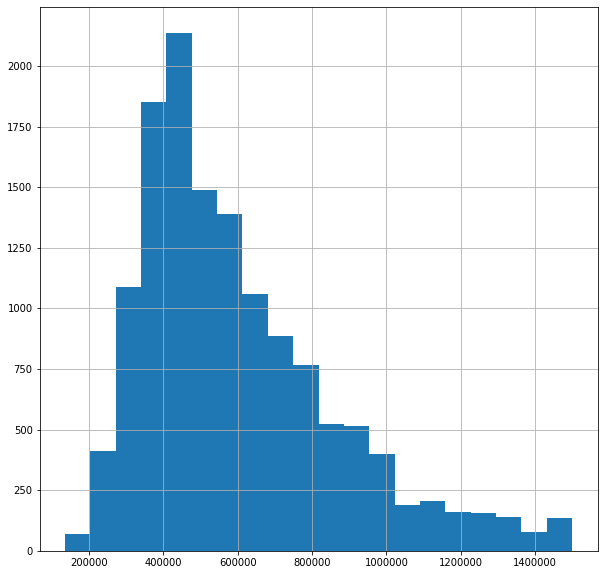

In [250]:
%matplotlib inline
Y_train.hist(bins=20, figsize=(10,10))

In [251]:
Y_train_log = np.log(Y_train)
Y_val_log=np.log(Y_val) 
Y_test_log = np.log(Y_test)

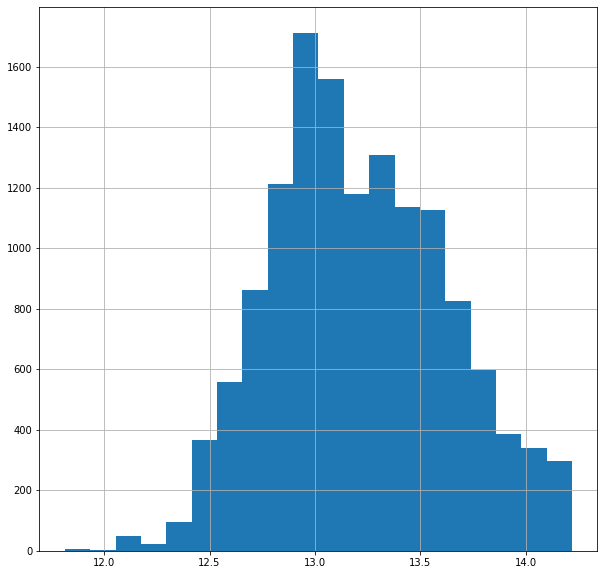

In [252]:
Y_train_log.hist(bins=20, figsize=(10,10))

## Model RandomForest

In [253]:
Y_train.shape

(13644,)

In [254]:
X_train.shape

(13644, 7)

In [337]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from ml_metrics import rmsle


model = RandomForestRegressor(random_state=2020, 
n_estimators=100, #default=100 #HYPEROPT DO ZASTOSOWANIA!
max_depth=15 #default=None
)
                              
model.fit(X_train, Y_train.values.ravel())

def custom_rmsle(model, X_test, Y_test):
    Y_pred=model.predict(X_test)
    Y_pred[Y_pred<0]=0
    
    return rmsle(Y_test, Y_pred)

cross_val_score(model, X_val, Y_val.values.ravel(), cv=5, scoring=custom_rmsle) #walidacja krzyżowa

array([0.18110138, 0.18994986, 0.19405128, 0.18331981, 0.16830872])

In [353]:
prediction=model.predict(X_test)
print(prediction-Y_test)

0       112145.618771
1        18660.975309
2         5856.382833
3       -43021.012820
4        10978.959430
5          542.795657
6        99989.611602
7         7254.113844
8      -139206.978813
9      -134866.371841
10       12150.058251
11       -4346.455009
12        1017.814486
13      -16411.047619
14      -26443.836993
15       11186.314416
16        4171.793089
17       13934.389986
18       12649.959952
19       13106.366265
20        3894.329422
21        1961.608190
22        2203.779929
23       11969.366421
24     -165601.716338
25        4193.752167
26          30.671703
27      -26835.174129
28       26098.556785
29        5735.264175
            ...      
4523    132321.629534
4524     -4420.266499
4525     81898.412101
4526      -614.691261
4527   -107192.000667
4528      3789.047619
4529    -16331.075000
4530    -41580.700995
4531   -175552.359280
4532      -237.630581
4533     96664.760603
4534    -36045.401788
4535    -14537.915865
4536     -9876.436692
4537    -2

In [348]:
Y_test

0        724779.0
1        379000.0
2        599000.0
3        630000.0
4        399000.0
5        598000.0
6        590000.0
7        545000.0
8        527900.0
9        630000.0
10       849000.0
11      1444096.0
12       499000.0
13       860000.0
14       720000.0
15       920000.0
16       434000.0
17       319000.0
18       419000.0
19       789000.0
20       258000.0
21       525800.0
22       675780.0
23       292635.0
24       920000.0
25       439000.0
26       849000.0
27       850000.0
28       615000.0
29       489000.0
          ...    
4523     409000.0
4524     649000.0
4525     479000.0
4526     330000.0
4527    1037671.0
4528     949000.0
4529     569000.0
4530     980000.0
4531     925000.0
4532     499000.0
4533     430000.0
4534     429000.0
4535     599000.0
4536     598000.0
4537     786435.0
4538     649000.0
4539    1299000.0
4540     407893.0
4541     749000.0
4542     298156.0
4543     755000.0
4544     749000.0
4545     571438.0
4546     485000.0
4547     6

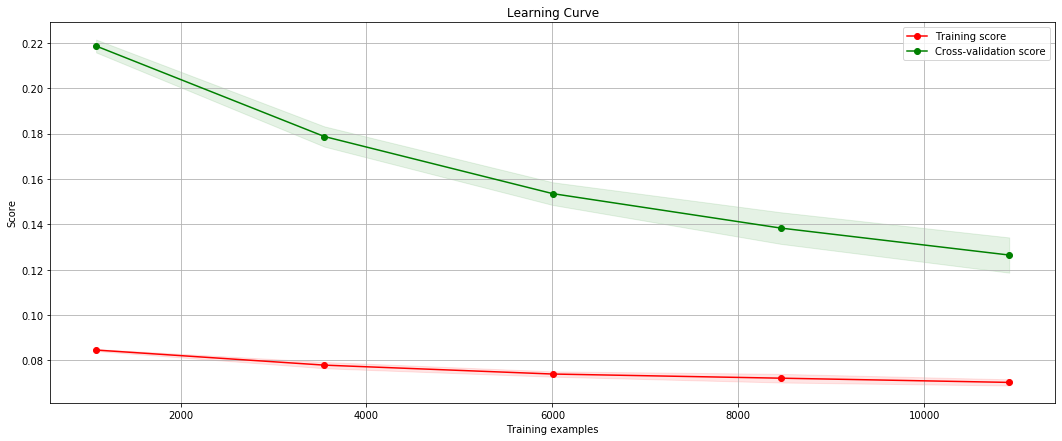

In [260]:
from scikitplot.estimators import plot_learning_curve
plot_learning_curve(model, X_train, Y_train.values.ravel(), cv=5, figsize=(18,7), scoring=custom_rmsle)

### Model RandomForest - zmienna objaśniająca (y) w postaci logarytmów

In [261]:
model.fit(X_train, Y_train_log.values.ravel())

def custom_rmsle(model, X_test, Y_test_log):
    Y_pred_log=model.predict(X_test)
    Y_pred_log[Y_pred_log<0]=0
    
    return rmsle(Y_test_log, Y_pred_log)

cross_val_score(model, X_val, Y_val_log.values.ravel(), cv=5, scoring=custom_rmsle) #walidacja krzyżowa

array([0.01266858, 0.01298512, 0.01352136, 0.01281695, 0.01175472])

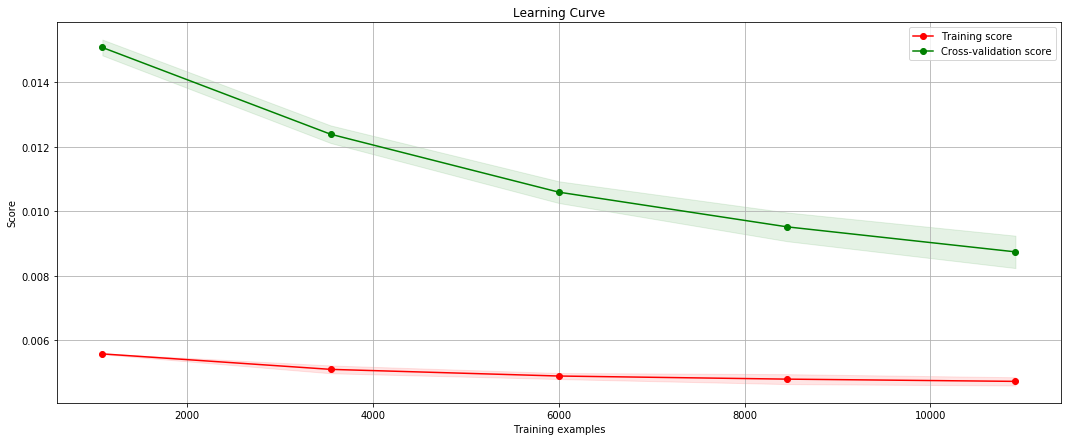

In [263]:
from scikitplot.estimators import plot_learning_curve
plot_learning_curve(model, X_train, Y_train_log.values.ravel(), cv=5, figsize=(18,7), scoring=custom_rmsle)

### Ważność cech w modelu

In [171]:
pip install sklearn.inspection

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement sklearn.inspection (from versions: none)
ERROR: No matching distribution found for sklearn.inspection


In [264]:
from eli5.sklearn import PermutationImportance
import eli5

In [266]:
zmienne=X_train.columns
zmienne=zmienne.tolist()
features = zmienne
perm = PermutationImportance(model, #random_state=123
                            ).fit(X_test, Y_test)
eli5.show_weights(perm, feature_names = features)

Weight,Feature
0.0000 ± 0.0000,powierzchnia
0.0000 ± 0.0000,rok_budowy
0.0000 ± 0.0000,miasto1
0.0000 ± 0.0000,liczba_pieter_budynku
0.0000 ± 0.0000,pietro
0.0000 ± 0.0000,liczba_pokoi
0.0000 ± 0.0000,rynek2


### GridSearchCV - Dobieranie najlepszych parametrów do modelu

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
grid_param = {  
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [4, 5, 6, 7],
    'max_features':[20,10,5,2],
    'min_samples_split':[200, 100,50,20]
}

In [98]:
grid_search = GridSearchCV(estimator=model,  
                     param_grid=grid_param,
                        scoring='r2')#DO POPRAWIENIA SCORING MAKE SCORER

In [99]:
grid_search.fit(X_train, y_train) 
 
best_parameters = grid_search.best_params_  
print(best_parameters) 
#{'max_depth': 7, 'max_features': 20, 'min_samples_split': 20, 'n_estimators': 500}

C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected

{'max_depth': 7, 'max_features': 20, 'min_samples_split': 20, 'n_estimators': 500}


In [95]:
model = RandomForestRegressor(**best_parameters)
model.fit(X_train, Y_train)  

C:\Users\kasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Random Search - Dobieranie najlepszych parametrów do modelu

In [137]:
from sklearn.model_selection import RandomizedSearchCV

In [146]:
random_param= {  
    'n_estimators': range(50, 100),
    'max_depth': range(4,6),
    'max_features':range(5,15),
    'min_samples_split':range(50,200)
}

In [147]:
random_search = RandomizedSearchCV(estimator=model
                                 , param_distributions=random_param
                                 , n_iter=4*4*4*2
                                 , scoring='r2' )

In [148]:
random_search.fit(X=X_train, y=Y_train)
 
best_parameters = random_search.best_params_  
print(best_parameters) 
#{'n_estimators': 56, 'min_samples_split': 50, 'max_features': 14, 'max_depth': 5}

C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\kasia\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y wa

{'n_estimators': 56, 'min_samples_split': 50, 'max_features': 14, 'max_depth': 5}


In [149]:
model = RandomForestRegressor(**best_parameters)
model.fit(X_train, Y_train)

C:\Users\kasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=14, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=56,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=14, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=56,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Feature engineering

https://www.kaggle.com/prestonfan/house-pricing-ultimate-guide

In [ ]:
#piętro+odległość od morza
#wysokość nad poziomem morza
#powierzchnia+liczba pokoi
#3 oddzielne modele dla Gdańska, Sopotu i Gdyni
#cena za metr zamiast prognozowania całkowitej ceny